In [1]:
#conda install -c conda-forge jupyterlab=3

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.1
  latest version: 4.10.1

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /Users/otaketomomi/anaconda3/envs/TF

  added / updated specs:
    - jupyterlab=3


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    anyio-3.2.1                |   py37hf985489_0         138 KB  conda-forge
    babel-2.9.1                |     pyh44b312d_0         6.2 MB  conda-forge
    ca-certificates-2021.5.30  |       h033912b_0         136 KB  conda-forge
    certifi-2021.5.30          |   py37hf985489_0         141 KB  conda-forge
    jupyter_server-1.9.0       |     pyhd8ed1ab_0         262 KB  conda-forge
    jupyterlab-3.0.16          |     pyhd8ed1ab_0         5.7 MB  conda-forge
    jupyterlab_server-2.6.0    |     pyhd8ed1ab_0  

# 準備

In [5]:
# 必要なパッケージの用意
import glob
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from sklearn import datasets
# trainとtestの比率が同じか確認
import collections

from sklearn.metrics import roc_curve, auc,recall_score, precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve

In [6]:
#現在の最大表示列数の出力
pd.get_option("display.max_columns")

#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 50)

## データの読み込み(1ストローク)

In [7]:
# データの読み込み
df_ori =  pd.read_csv("featMat.csv", sep=',', header=None)
df = df_ori.copy()
# df.head()

In [8]:
# 34 columns name update
df.columns = ['user', 'doc', 'stroke_inter', 'stroke_duration', 'start_x', 'start_y', 'stop_x', 'stop_y', 
              'direct_ete_distance', 'mean_result_leng', 'flag', 'direct_ete_line', 'phone', '20_pairwise_v', 
              '50_pairwise_v', '80_pairwise_v', '20_pairwise_acc', '50_pairwise_acc', '80_pairwise_acc', '3ots_m_v', 
              'ete_larg_deviation', '20_ete_line', '50_ete_line', '80_ete_line', 'ave_direction', 'length_trajectory', 
              'ratio_ete', 'ave_v', '5points_m_acc', 'm_stroke_press', 'm_stroke_area_cover', 'finger_orien',
              'cd_finger_orien', 'phone_orien' ]
# df.head()

In [9]:
# 欠損値削除
df_dropna = df.dropna(axis=0, how='any')
# df_dropna.isnull().sum()

ここまでは共通

## 実験プログラム

In [ ]:
df_dropna()

In [26]:
class FeaturesSelect():
    def __init__(self, columns_select, df_dropna, nfold):
        '''
        columns_select: 削除するカラム名
        df_dropna: データセット(欠損値処理済み)
        nfold: k分割交差検証におけるkの指定
        '''
        self.columns_select = columns_select
        df_dropna1 = df_dropna.copy()
        df_drop1 = df_dropna1.drop(columns_select, axis=1)
        self.df_drop = df_drop1
        self.nfold = nfold
    
    def train(self):
        df = self.df_drop.copy()
        
#         print(df.head())

        df1 = df.copy()
        df1["user"] = df1["user"]-1
        
#         print(df1.head())
        # 教師データの作成
        y = df1.user
        X = df1.drop("user", 1)

        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.2,
                                                            shuffle=True,
                                                            random_state=0,
                                                            stratify=y)
#         print(y_train)

        # 可視化のために特徴量の名前を渡しておく
        dtrain = xgb.DMatrix(X_train, label=y_train,
                             feature_names=df.columns[1:], silent=1)
        dtest = xgb.DMatrix(X_test, label=y_test,
                            feature_names=df.columns[1:], silent=1)

        print(collections.Counter(y_train))

        eval_metric = 'mlogloss'
        num_class = 41

        xgb_params = {
            # 多値分類問題
            'objective': 'multi:softmax',
            # クラス数
            'num_class': num_class,
            # 学習用の指標 (Multiclass logloss)
            'eval_metric': eval_metric,
        }

        # 交差検証する
        history = xgb.cv(xgb_params,
                         dtrain,
                         num_boost_round=1000,
                         early_stopping_rounds=10,
                         nfold=self.nfold,
                         # 層化分割する
                         stratified=True,
                         # 検証の経過を出力する
                         verbose_eval=10,
                         )

        # 学習時に用いる検証用データ
        evals = [(dtrain, 'train'), (dtest, 'eval')]

        # 学習過程を記録するための辞書
        evals_result = {}
        bst = xgb.train(xgb_params,
                        dtrain,
                        num_boost_round=1000,  # ラウンド数を増やしておく
                        early_stopping_rounds=10,
                        evals=evals,
                        evals_result=evals_result,
                        verbose_eval=10,
                        )

        y_pred = bst.predict(dtest)
        acc = accuracy_score(y_test, y_pred)
        f1score = f1_score(y_test, y_pred, average=None)
        print(f'Accuracy :', acc)
        print(f'F1-score :', f1score.mean())
        self.fimportance = bst.get_fscore()
        self.f1score = f1score
#         print(self.fimportance)
        self.bst = bst


        # 混同行列の計算
        df_accuracy = pd.DataFrame({'va_y': y_test,
                                'y_pred_max': y_pred})
        matrix = pd.crosstab(df_accuracy['va_y'], df_accuracy['y_pred_max'])

        print(f'nfold: {self.nfold}')
        # 学習の課程を折れ線グラフとしてプロットする
        test_metric = evals_result['eval'][eval_metric]
        plt.plot(test_metric, label='test logloss')
        train_metric = history['train-mlogloss-mean']
        plt.plot(train_metric, label='train logloss')
        eval_metric = history['test-mlogloss-mean']
        plt.plot(eval_metric, label='eval logloss')
        plt.grid()
        plt.legend()
        plt.xlabel('rounds')
        plt.ylabel('logloss')
        plt.show()



        def plot2(bst):
            # 性能向上に寄与する度合いで重要度をプロットする
            _, ax = plt.subplots(figsize=(12, 10))
            xgb.plot_importance(bst,
                                ax=ax,
                                importance_type='gain',
                                show_values=True)
            plt.show()

        plot2(bst)

        return X_train, X_test, y_train, y_test, matrix, y_pred

In [33]:
def check(X_train, X_test, y_train, y_test, matrix, y_pred):
    print(classification_report(y_test, y_pred))
#     fpr, tpr, _ = roc_curve(y_test, y_pred, average=None)
#     roc_auc = auc(fpr, tpr)
#     print(roc_auc)

In [28]:
columns_select1 = {'phone', 'finger_orien', 'cd_finger_orien'}

### 文献[1]にほぼ準拠

Counter({1: 970, 34: 849, 22: 750, 37: 623, 2: 606, 16: 564, 20: 560, 27: 558, 32: 547, 14: 536, 13: 518, 7: 492, 26: 486, 33: 486, 6: 467, 5: 448, 35: 394, 17: 367, 8: 361, 10: 355, 28: 344, 38: 343, 23: 343, 36: 338, 4: 329, 24: 328, 9: 308, 15: 304, 0: 304, 21: 295, 30: 294, 19: 283, 11: 273, 39: 248, 12: 244, 31: 242, 18: 234, 25: 182, 3: 181, 29: 178, 40: 146})
[0]	train-mlogloss:1.87903	eval-mlogloss:2.09835
[10]	train-mlogloss:0.57800	eval-mlogloss:1.04675
[20]	train-mlogloss:0.29418	eval-mlogloss:0.83568
[30]	train-mlogloss:0.15758	eval-mlogloss:0.74898
[40]	train-mlogloss:0.08838	eval-mlogloss:0.70429
[50]	train-mlogloss:0.05361	eval-mlogloss:0.67875
[60]	train-mlogloss:0.03567	eval-mlogloss:0.66455
[70]	train-mlogloss:0.02527	eval-mlogloss:0.65433
[80]	train-mlogloss:0.01908	eval-mlogloss:0.64960
[90]	train-mlogloss:0.01507	eval-mlogloss:0.64582
[100]	train-mlogloss:0.01243	eval-mlogloss:0.64265
[110]	train-mlogloss:0.01051	eval-mlogloss:0.64075
[120]	train-mlogloss:0.00914	e

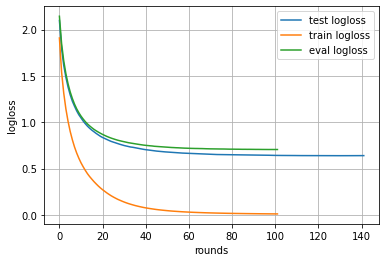

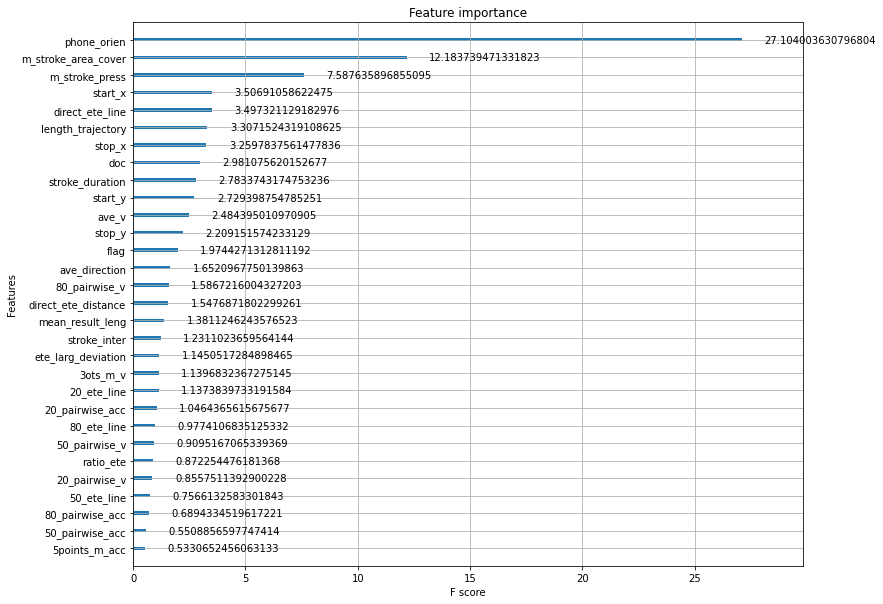

In [29]:
experiment1 = FeaturesSelect(columns_select1, df_dropna, nfold=5)
X_train1, X_test1, y_train1, y_test1, matrix1, y_pred1 = experiment1.train()

In [34]:
check(X_train1, X_test1, y_train1, y_test1, matrix1, y_pred1)

              precision    recall  f1-score   support

           0       0.86      0.83      0.85        76
           1       0.94      0.98      0.96       243
           2       0.68      0.66      0.67       151
           3       0.73      0.80      0.77        45
           4       0.84      0.76      0.79        82
           5       0.80      0.79      0.80       112
           6       0.73      0.85      0.78       117
           7       0.77      0.81      0.79       123
           8       0.84      0.92      0.88        90
           9       0.73      0.64      0.68        77
          10       0.79      0.72      0.75        89
          11       0.87      0.88      0.88        68
          12       0.82      0.80      0.81        61
          13       0.87      0.94      0.90       130
          14       0.95      0.92      0.93       134
          15       0.64      0.59      0.62        76
          16       0.77      0.82      0.80       141
          17       0.76    

### doc削除

In [35]:
columns_select2 = {'phone', 'finger_orien', 'cd_finger_orien', 'doc'}

Counter({1: 970, 34: 849, 22: 750, 37: 623, 2: 606, 16: 564, 20: 560, 27: 558, 32: 547, 14: 536, 13: 518, 7: 492, 26: 486, 33: 486, 6: 467, 5: 448, 35: 394, 17: 367, 8: 361, 10: 355, 28: 344, 38: 343, 23: 343, 36: 338, 4: 329, 24: 328, 9: 308, 15: 304, 0: 304, 21: 295, 30: 294, 19: 283, 11: 273, 39: 248, 12: 244, 31: 242, 18: 234, 25: 182, 3: 181, 29: 178, 40: 146})
[0]	train-mlogloss:1.90071	eval-mlogloss:2.12770
[10]	train-mlogloss:0.61407	eval-mlogloss:1.11133
[20]	train-mlogloss:0.32610	eval-mlogloss:0.91686
[30]	train-mlogloss:0.18498	eval-mlogloss:0.84310
[40]	train-mlogloss:0.10966	eval-mlogloss:0.80805
[50]	train-mlogloss:0.06894	eval-mlogloss:0.78534
[60]	train-mlogloss:0.04516	eval-mlogloss:0.77158
[70]	train-mlogloss:0.03228	eval-mlogloss:0.76444
[80]	train-mlogloss:0.02388	eval-mlogloss:0.75745
[90]	train-mlogloss:0.01854	eval-mlogloss:0.75840
Accuracy : 0.7839328537170264
F1-score : 0.7649683846785383
nfold: 5


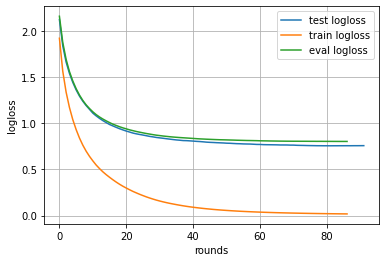

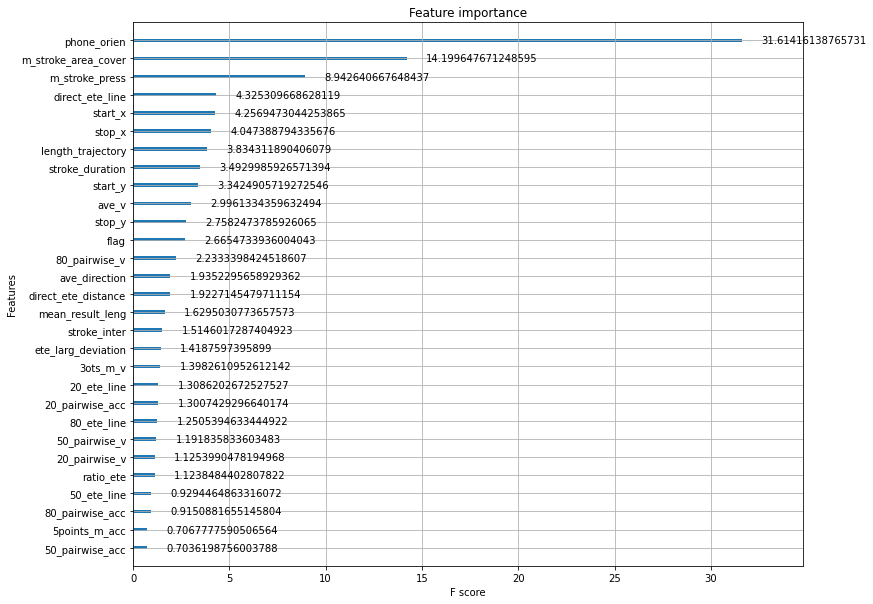

              precision    recall  f1-score   support

           0       0.82      0.79      0.81        76
           1       0.89      0.95      0.92       243
           2       0.68      0.64      0.66       151
           3       0.72      0.73      0.73        45
           4       0.74      0.68      0.71        82
           5       0.74      0.71      0.72       112
           6       0.75      0.79      0.77       117
           7       0.73      0.79      0.76       123
           8       0.76      0.91      0.83        90
           9       0.74      0.70      0.72        77
          10       0.76      0.73      0.75        89
          11       0.83      0.87      0.85        68
          12       0.77      0.70      0.74        61
          13       0.86      0.93      0.90       130
          14       0.94      0.92      0.93       134
          15       0.65      0.51      0.57        76
          16       0.76      0.75      0.75       141
          17       0.69    

In [36]:
experiment2 = FeaturesSelect(columns_select2, df_dropna, nfold=5)
X_train2, X_test2, y_train2, y_test2, matrix2, y_pred2 = experiment2.train()
check(X_train2, X_test2, y_train2, y_test2, matrix2, y_pred2)

In [114]:
experiment22 = FeaturesSelect(columns_select2, df_dropna, nfold=5)
X_train22, X_test22, y_train22, y_test22, matrix22, y_pred22 = experiment22.train()

12073     2
12087     2
14023    15
16707    31
12670     2
         ..
2547     23
552       0
20987    12
17362    29
19828    14
Name: user, Length: 16678, dtype: int64
Counter({1: 970, 34: 849, 22: 750, 37: 623, 2: 606, 16: 564, 20: 560, 27: 558, 32: 547, 14: 536, 13: 518, 7: 492, 26: 486, 33: 486, 6: 467, 5: 448, 35: 394, 17: 367, 8: 361, 10: 355, 28: 344, 38: 343, 23: 343, 36: 338, 4: 329, 24: 328, 9: 308, 15: 304, 0: 304, 21: 295, 30: 294, 19: 283, 11: 273, 39: 248, 12: 244, 31: 242, 18: 234, 25: 182, 3: 181, 29: 178, 40: 146})


KeyboardInterrupt: 

### 方向別

In [37]:
import sys
import os
sys.path.append(os.path.abspath(".."))
sys.path.append("../expmodule")
from expmodule.flag_split import flag4
# 変換表
# a = 1:up
# b = 2:left
# c = 3:down
# d = 4:right

In [38]:
# 上下左右のflagをもとにデータを分割
a, b, c, d = flag4(df_dropna, 'flag')
columns_select3 = {'phone', 'finger_orien', 'cd_finger_orien', 'doc'}

In [76]:
a.shape

(1278, 33)

In [77]:
b.shape

(4218, 33)

In [78]:
c.shape

(11102, 33)

In [79]:
d.shape

(4250, 33)

In [60]:
# up
experiment_a = FeaturesSelect(columns_select3, a, nfold=5)
X_train_a, X_test_a, y_train_a, y_test_a, matrix_a, y_pred_a = experiment_a.train()

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [ ]:
check(X_train_a, X_test_a, y_train_a, y_test_a, matrix_a, y_pred_a)

Counter({1: 742, 34: 566, 33: 434, 37: 391, 16: 370, 22: 365, 20: 335, 27: 327, 2: 298, 35: 262, 13: 257, 14: 251, 6: 235, 26: 234, 32: 234, 17: 219, 0: 196, 38: 195, 5: 195, 24: 180, 23: 170, 28: 169, 8: 169, 30: 163, 7: 162, 21: 157, 4: 157, 39: 143, 9: 126, 36: 124, 29: 120, 25: 113, 12: 111, 11: 111, 31: 98, 10: 96, 15: 94, 19: 93, 18: 91, 3: 75, 40: 53})
[0]	train-mlogloss:1.47158	eval-mlogloss:1.71029
[10]	train-mlogloss:0.33486	eval-mlogloss:0.86684
[20]	train-mlogloss:0.12592	eval-mlogloss:0.72977
[30]	train-mlogloss:0.05434	eval-mlogloss:0.68952
[40]	train-mlogloss:0.02977	eval-mlogloss:0.67941
[50]	train-mlogloss:0.01966	eval-mlogloss:0.67645
[60]	train-mlogloss:0.01476	eval-mlogloss:0.67561
[65]	train-mlogloss:0.01310	eval-mlogloss:0.67609
Accuracy : 0.8090950022512382
F1-score : 0.7711961813962515
nfold: 5


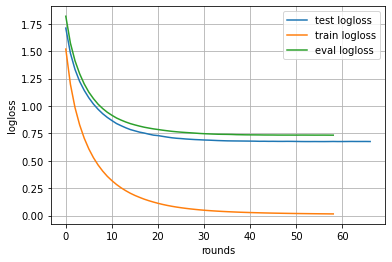

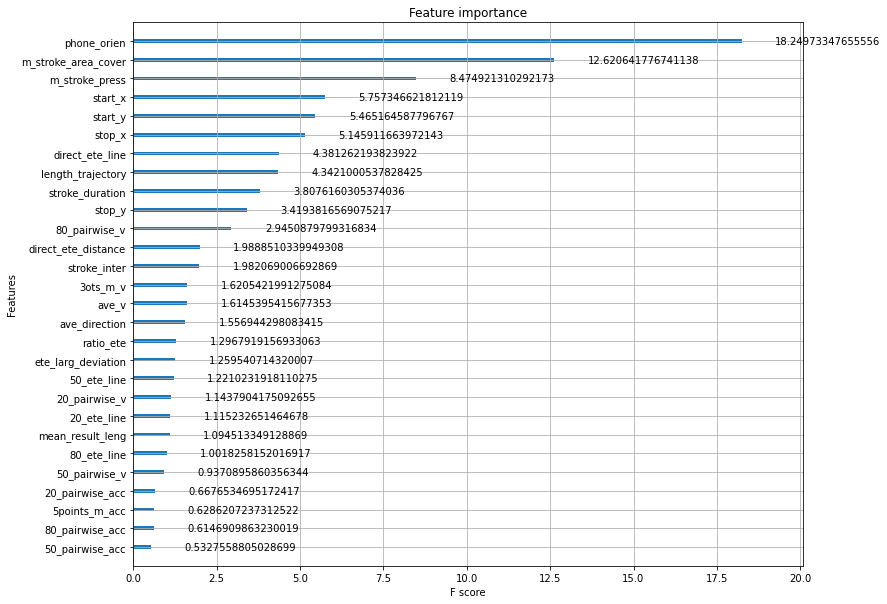

In [39]:
# down
experiment_c = FeaturesSelect(columns_select3, c, nfold=5)
X_train_c, X_test_c, y_train_c, y_test_c, matrix_c, y_pred_c = experiment_c.train()

In [40]:
check(X_train_c, X_test_c, y_train_c, y_test_c, matrix_c, y_pred_c)

              precision    recall  f1-score   support

           0       0.89      0.82      0.85        49
           1       0.93      0.98      0.96       186
           2       0.57      0.68      0.62        74
           3       0.81      0.89      0.85        19
           4       0.50      0.49      0.49        39
           5       0.78      0.78      0.78        49
           6       0.74      0.73      0.74        59
           7       0.73      0.75      0.74        40
           8       0.85      0.83      0.84        42
           9       0.62      0.52      0.56        31
          10       0.87      0.54      0.67        24
          11       0.80      0.71      0.75        28
          12       0.63      0.61      0.62        28
          13       0.83      0.84      0.84        64
          14       0.95      0.95      0.95        63
          15       0.61      0.61      0.61        23
          16       0.77      0.83      0.80        93
          17       0.81    

Counter({7: 158, 22: 137, 32: 131, 2: 130, 34: 129, 10: 123, 26: 122, 14: 120, 5: 115, 13: 112, 27: 101, 15: 100, 36: 98, 1: 95, 20: 94, 16: 90, 19: 88, 6: 86, 9: 86, 8: 86, 28: 85, 37: 83, 11: 80, 4: 74, 17: 71, 31: 68, 12: 65, 30: 63, 23: 62, 38: 62, 24: 56, 35: 55, 18: 51, 21: 50, 0: 50, 39: 48, 3: 46, 40: 43, 33: 22, 25: 20, 29: 19})
[0]	train-mlogloss:1.69565	eval-mlogloss:2.04456
[10]	train-mlogloss:0.27088	eval-mlogloss:1.03156
[20]	train-mlogloss:0.07950	eval-mlogloss:0.89240
[30]	train-mlogloss:0.03802	eval-mlogloss:0.85035
[40]	train-mlogloss:0.02508	eval-mlogloss:0.84080
[50]	train-mlogloss:0.01942	eval-mlogloss:0.83783
[60]	train-mlogloss:0.01626	eval-mlogloss:0.83891
[62]	train-mlogloss:0.01581	eval-mlogloss:0.83868
Accuracy : 0.7677725118483413
F1-score : 0.7503774378314838
nfold: 5


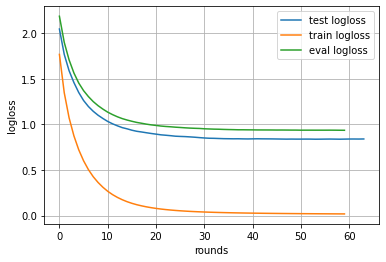

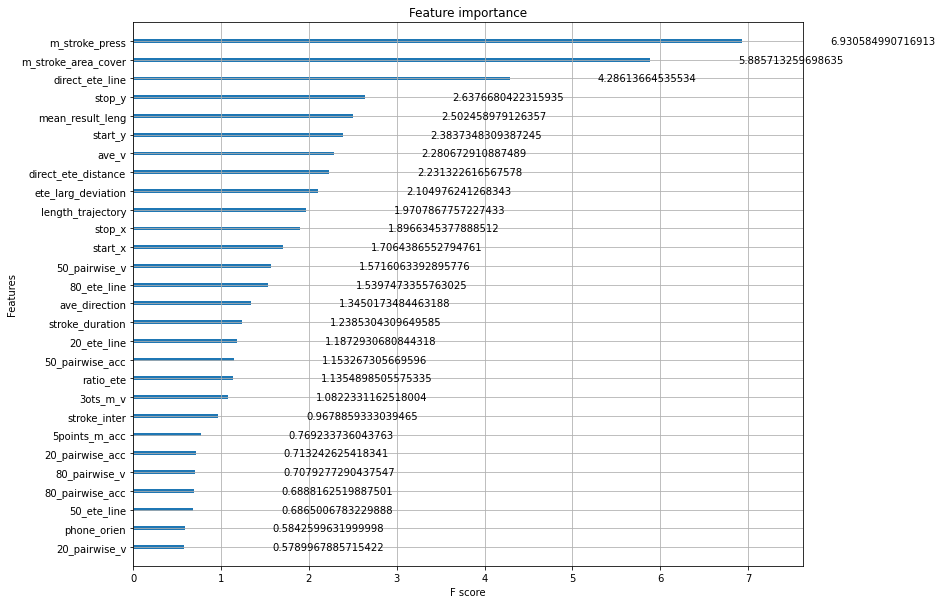

In [41]:
# left
experiment_b = FeaturesSelect(columns_select3, b, nfold=5)
X_train_b, X_test_b, y_train_b, y_test_b, matrix_b, y_pred_b = experiment_b.train()

In [42]:
check(X_train_b, X_test_b, y_train_b, y_test_b, matrix_b, y_pred_b)

              precision    recall  f1-score   support

           0       0.56      0.77      0.65        13
           1       0.71      0.83      0.77        24
           2       0.74      0.78      0.76        32
           3       0.88      0.58      0.70        12
           4       0.89      0.84      0.86        19
           5       0.80      0.69      0.74        29
           6       0.74      0.67      0.70        21
           7       0.77      0.90      0.83        40
           8       0.84      0.95      0.89        22
           9       0.78      0.64      0.70        22
          10       0.79      0.84      0.81        31
          11       0.95      0.90      0.92        20
          12       0.79      0.69      0.73        16
          13       0.73      0.79      0.76        28
          14       0.96      0.87      0.91        30
          15       0.71      0.68      0.69        25
          16       0.70      0.83      0.76        23
          17       0.62    

Counter({7: 155, 34: 144, 32: 139, 22: 132, 2: 129, 10: 127, 26: 117, 5: 113, 15: 106, 13: 105, 27: 105, 36: 103, 14: 100, 20: 95, 16: 95, 1: 94, 19: 88, 8: 88, 9: 88, 28: 86, 6: 83, 11: 81, 37: 76, 31: 72, 4: 70, 17: 68, 38: 64, 30: 60, 23: 60, 12: 58, 24: 58, 35: 58, 3: 56, 18: 54, 21: 53, 39: 50, 0: 50, 40: 47, 25: 29, 33: 24, 29: 20})
[0]	train-mlogloss:1.71365	eval-mlogloss:2.14855
[10]	train-mlogloss:0.28440	eval-mlogloss:1.13836
[20]	train-mlogloss:0.08422	eval-mlogloss:0.99807
[30]	train-mlogloss:0.04006	eval-mlogloss:0.96519
[40]	train-mlogloss:0.02596	eval-mlogloss:0.95568
[50]	train-mlogloss:0.01993	eval-mlogloss:0.94839
[60]	train-mlogloss:0.01672	eval-mlogloss:0.94670
[70]	train-mlogloss:0.01465	eval-mlogloss:0.94701
[75]	train-mlogloss:0.01390	eval-mlogloss:0.94617
Accuracy : 0.74
F1-score : 0.734355175682828
nfold: 5


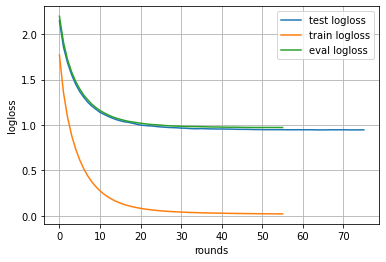

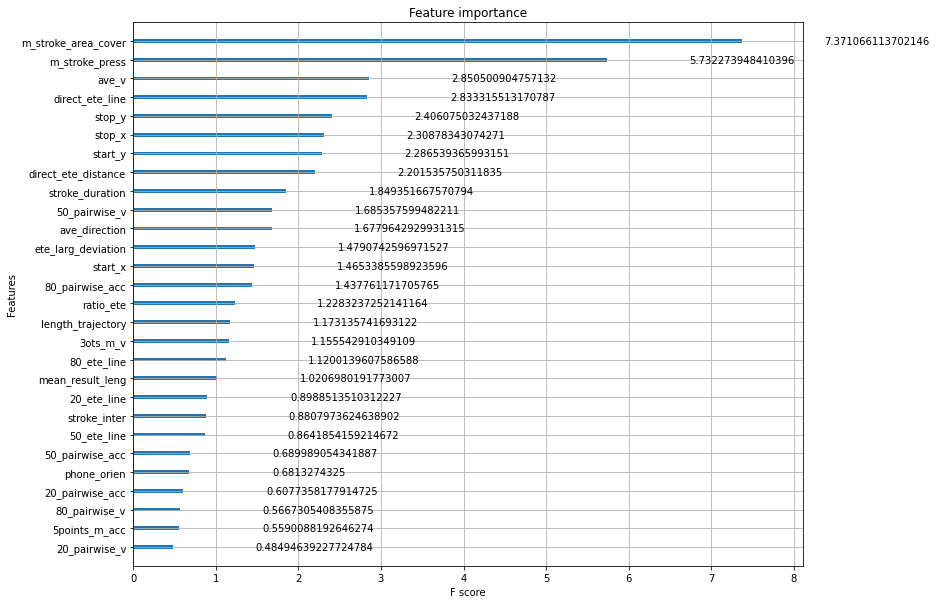

In [43]:
# right
experiment_d = FeaturesSelect(columns_select3, d, nfold=5)
X_train_d, X_test_d, y_train_d, y_test_d, matrix_d, y_pred_d = experiment_d.train()

In [44]:
check(X_train_d, X_test_d, y_train_d, y_test_d, matrix_d, y_pred_d)

              precision    recall  f1-score   support

           0       0.64      0.54      0.58        13
           1       0.83      0.83      0.83        23
           2       0.81      0.66      0.72        32
           3       0.71      0.86      0.77        14
           4       0.85      0.61      0.71        18
           5       0.61      0.71      0.66        28
           6       0.83      0.71      0.77        21
           7       0.78      0.82      0.80        39
           8       0.83      0.86      0.84        22
           9       0.65      0.77      0.71        22
          10       0.71      0.69      0.70        32
          11       0.89      0.85      0.87        20
          12       0.77      0.71      0.74        14
          13       0.95      0.81      0.88        26
          14       0.70      0.92      0.79        25
          15       0.55      0.59      0.57        27
          16       0.61      0.46      0.52        24
          17       0.80    

## データの読み込み(2ストローク)

In [45]:
from expmodule.flag_split import flag16

In [46]:
df_ori_t = pd.read_csv('/Users/otaketomomi/PycharmProjects/PAuth/dataset_create/expdata_doc.csv', sep=',')
df_ori_t1 = df_ori_t.copy()

In [52]:
df_drop_t2 = df_ori_t1.drop({'Unnamed: 0', 'flag', 'finger_orien', 'cd_finger_orien', 'phone_orien',
                           'user2', 'doc2', 'flag2', 'finger_orien2', 'cd_finger_orien2', 'phone_orien2',
                           'user_ave', 'doc_ave', 'flag_ave', 'finger_orien_ave', 'cd_finger_orien_ave',
                           'phone_orien_ave'}, axis=1)

# 平均したものを削除
df_drop_t3 = df_drop_t2.drop({'stroke_inter_ave', 'stroke_duration_ave', 'start_x_ave', 'start_y_ave',
                             'stop_x_ave', 'stop_y_ave', 'direct_ete_distance_ave', 'mean_result_leng_ave',
                             'direct_ete_line_ave', '20_pairwise_v_ave', '50_pairwise_v_ave', '80_pairwise_v_ave',
                             '20_pairwise_acc_ave', '50_pairwise_acc_ave', '80_pairwise_acc_ave', '3ots_m_v_ave',
                             'ete_larg_deviation_ave', '20_ete_line_ave', '50_ete_line_ave', '80_ete_line_ave',
                             'ave_direction_ave', 'length_trajectory_ave', 'ratio_ete_ave', 'ave_v_ave',
                             '5points_m_acc_ave', 'm_stroke_press_ave', 'm_stroke_area_cover_ave'}, axis=1)


In [53]:
df_drop_t3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20399 entries, 0 to 20398
Data columns (total 67 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user                  20399 non-null  int64  
 1   doc                   20399 non-null  int64  
 2   stroke_inter          20399 non-null  float64
 3   stroke_duration       20399 non-null  float64
 4   start_x               20399 non-null  float64
 5   start_y               20399 non-null  float64
 6   stop_x                20399 non-null  float64
 7   stop_y                20399 non-null  float64
 8   direct_ete_distance   20399 non-null  float64
 9   mean_result_leng      20399 non-null  float64
 10  direct_ete_line       20399 non-null  float64
 11  20_pairwise_v         20399 non-null  float64
 12  50_pairwise_v         20399 non-null  float64
 13  80_pairwise_v         20399 non-null  float64
 14  20_pairwise_acc       20399 non-null  float64
 15  50_pairwise_acc    

### 方向を考慮なし

In [54]:
columns_select_mf = {'Unnamed: 0', 'flag', 'finger_orien', 'cd_finger_orien', 'phone_orien',
                     'user2', 'doc2', 'flag2', 'finger_orien2', 'cd_finger_orien2', 'phone_orien2',
                     'user_ave', 'doc_ave', 'flag_ave', 'finger_orien_ave', 'cd_finger_orien_ave',
                     'phone_orien_ave', 'stroke_inter_ave', 'stroke_duration_ave', 'start_x_ave', 'start_y_ave',
                     'stop_x_ave', 'stop_y_ave', 'direct_ete_distance_ave', 'mean_result_leng_ave',
                     'direct_ete_line_ave', '20_pairwise_v_ave', '50_pairwise_v_ave', '80_pairwise_v_ave',
                     '20_pairwise_acc_ave', '50_pairwise_acc_ave', '80_pairwise_acc_ave', '3ots_m_v_ave',
                     'ete_larg_deviation_ave', '20_ete_line_ave', '50_ete_line_ave', '80_ete_line_ave',
                     'ave_direction_ave', 'length_trajectory_ave', 'ratio_ete_ave', 'ave_v_ave',
                     '5points_m_acc_ave', 'm_stroke_press_ave', 'm_stroke_area_cover_ave'}

Counter({1: 954, 34: 842, 22: 726, 37: 615, 2: 599, 16: 560, 20: 554, 27: 543, 32: 526, 13: 513, 14: 505, 7: 485, 26: 481, 33: 478, 6: 458, 5: 442, 35: 385, 17: 362, 8: 354, 10: 350, 28: 336, 23: 335, 36: 334, 38: 334, 4: 323, 24: 311, 9: 302, 15: 298, 21: 289, 30: 288, 0: 287, 19: 278, 11: 269, 39: 244, 12: 240, 31: 237, 18: 230, 29: 172, 25: 172, 3: 169, 40: 139})
[0]	train-mlogloss:1.82382	eval-mlogloss:2.10115
[10]	train-mlogloss:0.42823	eval-mlogloss:0.93073
[20]	train-mlogloss:0.16494	eval-mlogloss:0.68687
[30]	train-mlogloss:0.07027	eval-mlogloss:0.57673
[40]	train-mlogloss:0.03536	eval-mlogloss:0.51848
[50]	train-mlogloss:0.02058	eval-mlogloss:0.48386
[60]	train-mlogloss:0.01372	eval-mlogloss:0.46484
[70]	train-mlogloss:0.01012	eval-mlogloss:0.45059
[80]	train-mlogloss:0.00801	eval-mlogloss:0.44121
[90]	train-mlogloss:0.00668	eval-mlogloss:0.43434
[100]	train-mlogloss:0.00579	eval-mlogloss:0.43056
[110]	train-mlogloss:0.00515	eval-mlogloss:0.42664
[120]	train-mlogloss:0.00466	e

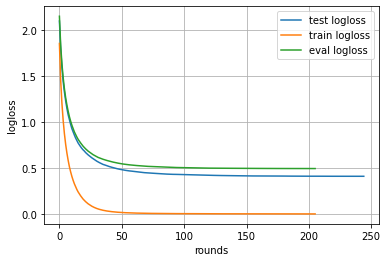

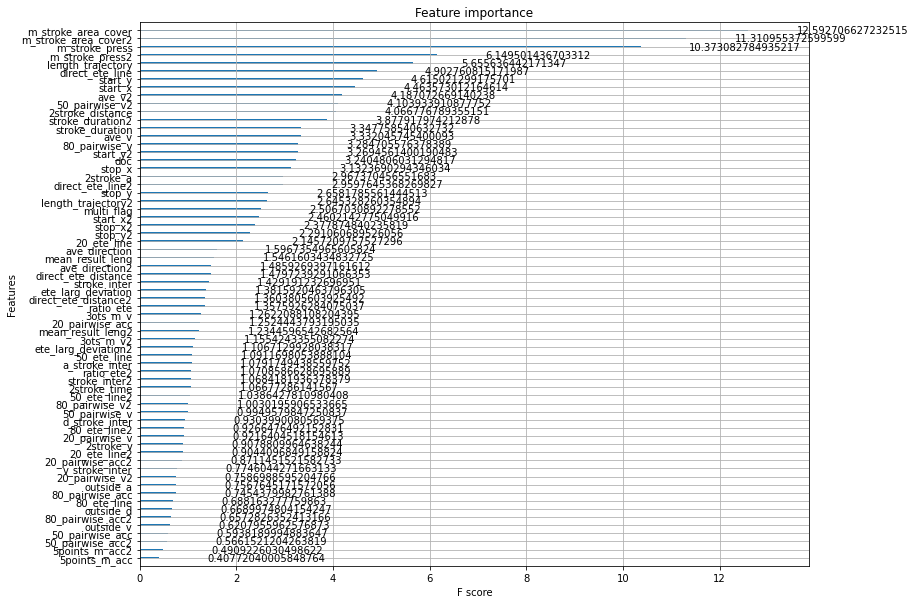

In [55]:
# 2ストローク(方向考慮なし)
experiment_mf = FeaturesSelect(columns_select_mf, df_ori_t1, nfold=5)
X_train_mf, X_test_mf, y_train_mf, y_test_mf, matrix_mf, y_pred_mf = experiment_mf.train()

In [56]:
check(X_train_mf, X_test_mf, y_train_mf, y_test_mf, matrix_mf, y_pred_mf)

              precision    recall  f1-score   support

           0       0.87      0.82      0.84        72
           1       0.97      0.97      0.97       239
           2       0.70      0.70      0.70       150
           3       0.92      0.83      0.88        42
           4       0.87      0.91      0.89        81
           5       0.88      0.90      0.89       110
           6       0.85      0.91      0.88       115
           7       0.83      0.96      0.89       121
           8       0.91      0.97      0.93        89
           9       0.85      0.80      0.82        75
          10       0.78      0.84      0.81        87
          11       0.94      0.91      0.92        67
          12       0.87      0.75      0.80        60
          13       0.89      0.92      0.91       128
          14       0.95      0.93      0.94       126
          15       0.79      0.78      0.79        74
          16       0.84      0.84      0.84       140
          17       0.89    

In [57]:
# docあり
columns_select_mf2 = {'Unnamed: 0', 'flag', 'finger_orien', 'cd_finger_orien',
                     'user2', 'doc2', 'flag2', 'finger_orien2', 'cd_finger_orien2',
                     'user_ave', 'doc_ave', 'flag_ave', 'finger_orien_ave', 'cd_finger_orien_ave',
                     'phone_orien_ave', 'stroke_inter_ave', 'stroke_duration_ave', 'start_x_ave', 'start_y_ave',
                     'stop_x_ave', 'stop_y_ave', 'direct_ete_distance_ave', 'mean_result_leng_ave',
                     'direct_ete_line_ave', '20_pairwise_v_ave', '50_pairwise_v_ave', '80_pairwise_v_ave',
                     '20_pairwise_acc_ave', '50_pairwise_acc_ave', '80_pairwise_acc_ave', '3ots_m_v_ave',
                     'ete_larg_deviation_ave', '20_ete_line_ave', '50_ete_line_ave', '80_ete_line_ave',
                     'ave_direction_ave', 'length_trajectory_ave', 'ratio_ete_ave', 'ave_v_ave',
                     '5points_m_acc_ave', 'm_stroke_press_ave', 'm_stroke_area_cover_ave'}

Counter({1: 954, 34: 842, 22: 726, 37: 615, 2: 599, 16: 560, 20: 554, 27: 543, 32: 526, 13: 513, 14: 505, 7: 485, 26: 481, 33: 478, 6: 458, 5: 442, 35: 385, 17: 362, 8: 354, 10: 350, 28: 336, 23: 335, 36: 334, 38: 334, 4: 323, 24: 311, 9: 302, 15: 298, 21: 289, 30: 288, 0: 287, 19: 278, 11: 269, 39: 244, 12: 240, 31: 237, 18: 230, 29: 172, 25: 172, 3: 169, 40: 139})
[0]	train-mlogloss:1.81792	eval-mlogloss:2.09378
[10]	train-mlogloss:0.41546	eval-mlogloss:0.90896
[20]	train-mlogloss:0.16174	eval-mlogloss:0.66569
[30]	train-mlogloss:0.06939	eval-mlogloss:0.56457
[40]	train-mlogloss:0.03413	eval-mlogloss:0.50808
[50]	train-mlogloss:0.01989	eval-mlogloss:0.47714
[60]	train-mlogloss:0.01332	eval-mlogloss:0.45797
[70]	train-mlogloss:0.00988	eval-mlogloss:0.44709
[80]	train-mlogloss:0.00786	eval-mlogloss:0.43905
[90]	train-mlogloss:0.00660	eval-mlogloss:0.43337
[100]	train-mlogloss:0.00572	eval-mlogloss:0.43010
[110]	train-mlogloss:0.00508	eval-mlogloss:0.42664
[120]	train-mlogloss:0.00461	e

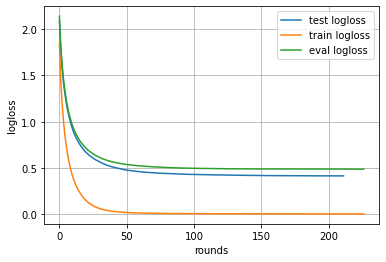

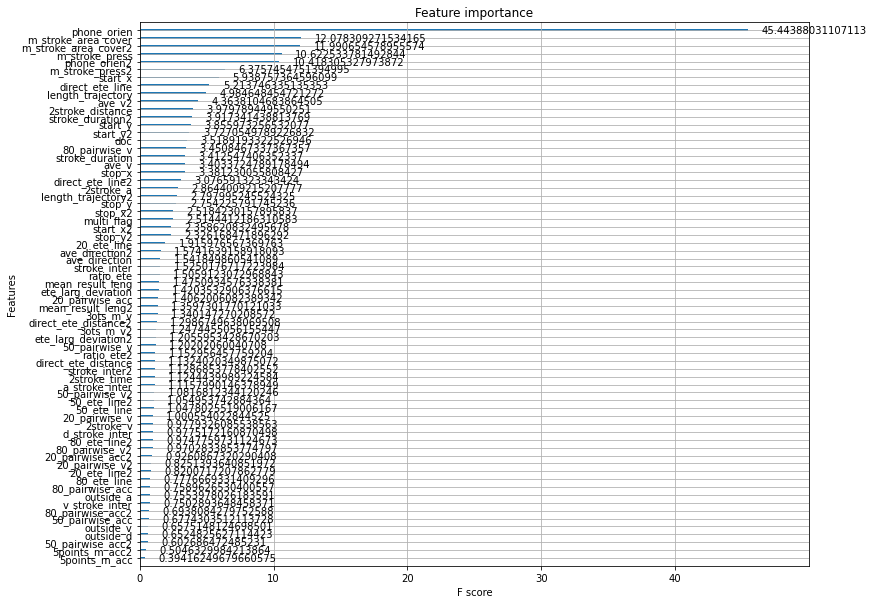

In [58]:
# 2ストローク(方向考慮なし)
# phone_orien追加
experiment_mf2 = FeaturesSelect(columns_select_mf2, df_ori_t1, nfold=5)
X_train_mf2, X_test_mf2, y_train_mf2, y_test_mf2, matrix_mf2, y_pred_mf2 = experiment_mf2.train()

In [59]:
check(X_train_mf2, X_test_mf2, y_train_mf2, y_test_mf2, matrix_mf2, y_pred_mf2)

              precision    recall  f1-score   support

           0       0.88      0.82      0.85        72
           1       0.96      0.98      0.97       239
           2       0.67      0.68      0.67       150
           3       0.88      0.83      0.85        42
           4       0.84      0.89      0.86        81
           5       0.87      0.90      0.88       110
           6       0.84      0.85      0.85       115
           7       0.84      0.93      0.88       121
           8       0.91      0.97      0.94        89
           9       0.77      0.77      0.77        75
          10       0.81      0.84      0.82        87
          11       0.92      0.88      0.90        67
          12       0.88      0.73      0.80        60
          13       0.89      0.95      0.92       128
          14       0.95      0.91      0.93       126
          15       0.78      0.80      0.79        74
          16       0.84      0.85      0.84       140
          17       0.88    

In [60]:
columns_select_mf3 = {'Unnamed: 0', 'flag', 'finger_orien', 'cd_finger_orien', 'doc',
                     'user2', 'doc2', 'flag2', 'finger_orien2', 'cd_finger_orien2',
                     'user_ave', 'doc_ave', 'flag_ave', 'finger_orien_ave', 'cd_finger_orien_ave',
                     'phone_orien_ave', 'stroke_inter_ave', 'stroke_duration_ave', 'start_x_ave', 'start_y_ave',
                     'stop_x_ave', 'stop_y_ave', 'direct_ete_distance_ave', 'mean_result_leng_ave',
                     'direct_ete_line_ave', '20_pairwise_v_ave', '50_pairwise_v_ave', '80_pairwise_v_ave',
                     '20_pairwise_acc_ave', '50_pairwise_acc_ave', '80_pairwise_acc_ave', '3ots_m_v_ave',
                     'ete_larg_deviation_ave', '20_ete_line_ave', '50_ete_line_ave', '80_ete_line_ave',
                     'ave_direction_ave', 'length_trajectory_ave', 'ratio_ete_ave', 'ave_v_ave',
                     '5points_m_acc_ave', 'm_stroke_press_ave', 'm_stroke_area_cover_ave'}

Counter({1: 954, 34: 842, 22: 726, 37: 615, 2: 599, 16: 560, 20: 554, 27: 543, 32: 526, 13: 513, 14: 505, 7: 485, 26: 481, 33: 478, 6: 458, 5: 442, 35: 385, 17: 362, 8: 354, 10: 350, 28: 336, 23: 335, 36: 334, 38: 334, 4: 323, 24: 311, 9: 302, 15: 298, 21: 289, 30: 288, 0: 287, 19: 278, 11: 269, 39: 244, 12: 240, 31: 237, 18: 230, 29: 172, 25: 172, 3: 169, 40: 139})
[0]	train-mlogloss:1.83758	eval-mlogloss:2.11802
[10]	train-mlogloss:0.43920	eval-mlogloss:0.95733
[20]	train-mlogloss:0.17353	eval-mlogloss:0.72468
[30]	train-mlogloss:0.07788	eval-mlogloss:0.62855
[40]	train-mlogloss:0.03863	eval-mlogloss:0.57371
[50]	train-mlogloss:0.02272	eval-mlogloss:0.54365
[60]	train-mlogloss:0.01494	eval-mlogloss:0.52566
[70]	train-mlogloss:0.01105	eval-mlogloss:0.51475
[80]	train-mlogloss:0.00866	eval-mlogloss:0.50687
[90]	train-mlogloss:0.00721	eval-mlogloss:0.50264
[100]	train-mlogloss:0.00620	eval-mlogloss:0.49842
[110]	train-mlogloss:0.00548	eval-mlogloss:0.49618
[120]	train-mlogloss:0.00495	e

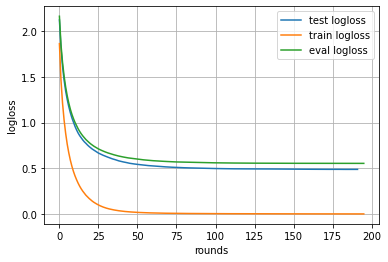

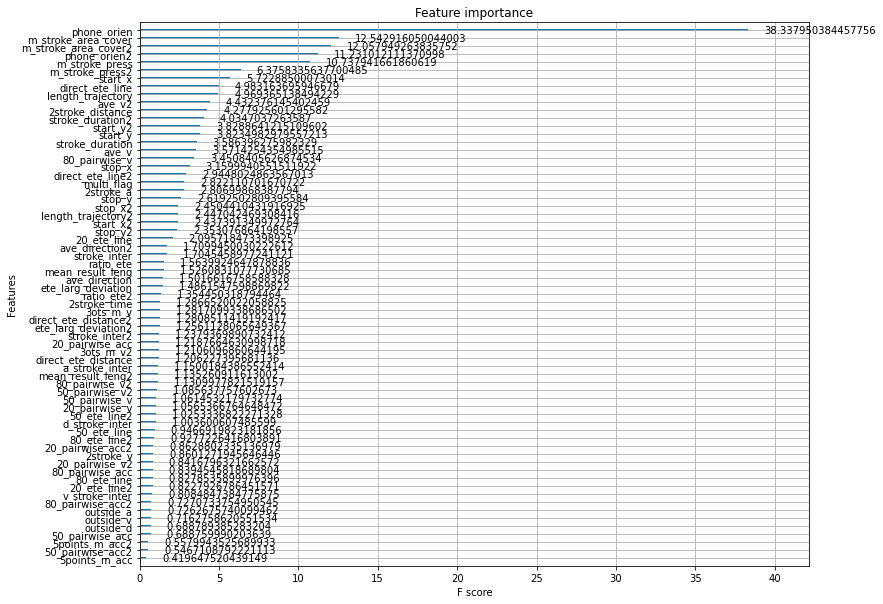

In [61]:
# 2ストローク(方向考慮なし)
# doc削除
experiment_mf3 = FeaturesSelect(columns_select_mf3, df_ori_t1, nfold=5)
X_train_mf3, X_test_mf3, y_train_mf3, y_test_mf3, matrix_mf3, y_pred_mf3 = experiment_mf3.train()

In [62]:
check(X_train_mf3, X_test_mf3, y_train_mf3, y_test_mf3, matrix_mf3, y_pred_mf3)

              precision    recall  f1-score   support

           0       0.88      0.83      0.86        72
           1       0.95      0.96      0.96       239
           2       0.64      0.64      0.64       150
           3       0.86      0.86      0.86        42
           4       0.77      0.80      0.79        81
           5       0.78      0.83      0.80       110
           6       0.85      0.87      0.86       115
           7       0.82      0.93      0.87       121
           8       0.88      0.96      0.91        89
           9       0.79      0.72      0.76        75
          10       0.79      0.85      0.82        87
          11       0.88      0.88      0.88        67
          12       0.80      0.65      0.72        60
          13       0.92      0.95      0.93       128
          14       0.96      0.91      0.93       126
          15       0.78      0.77      0.78        74
          16       0.82      0.80      0.81       140
          17       0.80    

### ストローク方向

In [99]:
# 上下左右のflagをもとにデータを分割
aa, ab, ac, ad, ba, bb, bc, bd, ca, cb, cc, cd, da, db, dc, dd = flag16(df_ori_t1, 'multi_flag')
# experiment_mf3を使用
cc.shape

(10056, 110)

Counter({1: 712, 34: 541, 33: 425, 16: 361, 37: 337, 22: 316, 20: 304, 27: 298, 2: 266, 35: 246, 13: 243, 26: 215, 14: 207, 17: 204, 6: 190, 32: 189, 0: 186, 5: 177, 38: 170, 28: 159, 8: 155, 30: 153, 7: 142, 24: 142, 21: 138, 39: 137, 4: 136, 23: 134, 36: 115, 9: 113, 11: 107, 29: 106, 12: 98, 31: 93, 25: 90, 10: 85, 15: 83, 19: 82, 18: 74, 3: 69, 40: 46})
[0]	train-mlogloss:1.39023	eval-mlogloss:1.74816
[10]	train-mlogloss:0.20324	eval-mlogloss:0.75551
[20]	train-mlogloss:0.05484	eval-mlogloss:0.57638
[30]	train-mlogloss:0.02301	eval-mlogloss:0.51828
[40]	train-mlogloss:0.01355	eval-mlogloss:0.48992
[50]	train-mlogloss:0.00974	eval-mlogloss:0.47823
[60]	train-mlogloss:0.00782	eval-mlogloss:0.47342
[70]	train-mlogloss:0.00669	eval-mlogloss:0.46966
[80]	train-mlogloss:0.00595	eval-mlogloss:0.46773
[90]	train-mlogloss:0.00541	eval-mlogloss:0.46657
[100]	train-mlogloss:0.00502	eval-mlogloss:0.46552
[108]	train-mlogloss:0.00477	eval-mlogloss:0.46558
Accuracy : 0.8623260437375746
F1-score 

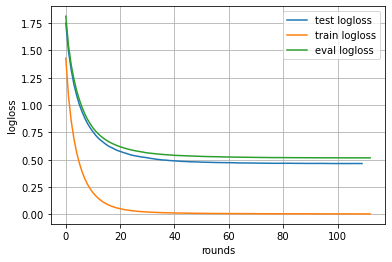

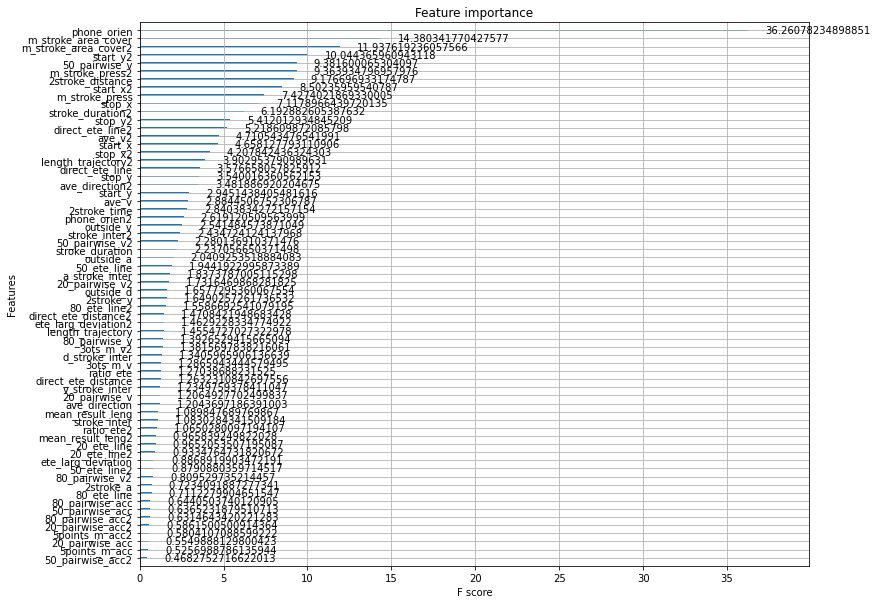

In [100]:
# 2ストローク(方向考慮あり)
# doc削除
experiment_mf3_cc = FeaturesSelect(columns_select_mf3, cc, nfold=5)
X_train_mf3_cc, X_test_mf3_cc, y_train_mf3_cc, y_test_mf3_cc, matrix_mf3_cc, y_pred_mf3_cc = experiment_mf3_cc.train()


In [101]:
check(X_train_mf3_cc, X_test_mf3_cc, y_train_mf3_cc, y_test_mf3_cc, matrix_mf3_cc, y_pred_mf3_cc)

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        46
           1       0.96      0.99      0.98       178
           2       0.66      0.71      0.69        66
           3       1.00      0.76      0.87        17
           4       0.68      0.74      0.70        34
           5       0.86      0.82      0.84        44
           6       0.77      0.77      0.77        47
           7       0.80      0.91      0.85        35
           8       0.87      0.85      0.86        39
           9       0.80      0.71      0.75        28
          10       0.74      0.81      0.77        21
          11       0.85      0.85      0.85        27
          12       0.79      0.76      0.78        25
          13       0.93      0.92      0.93        61
          14       0.96      0.90      0.93        52
          15       0.91      0.48      0.62        21
          16       0.88      0.85      0.86        91
          17       0.86    

Counter({1: 970, 34: 849, 22: 750, 37: 623, 2: 606, 16: 564, 20: 560, 27: 558, 32: 547, 14: 536, 13: 518, 7: 492, 26: 486, 33: 486, 6: 467, 5: 448, 35: 394, 17: 367, 8: 361, 10: 355, 28: 344, 38: 343, 23: 343, 36: 338, 4: 329, 24: 328, 9: 308, 15: 304, 0: 304, 21: 295, 30: 294, 19: 283, 11: 273, 39: 248, 12: 244, 31: 242, 18: 234, 25: 182, 3: 181, 29: 178, 40: 146})

'2stroke_time': D_total, 
'd_stroke_inter': d_inter, 'v_stroke_inter': v_inter,
'a_stroke_inter': a_inter, '2stroke_distance': d_sum,
'2stroke_v': v_outer, '2stroke_a': a_outer, 
'outside_d': d_outside,
'outside_v': v_outside, 'outside_a': a_outside}

## データ数の制限

### 実験プログラム(データ数制限用)

In [63]:
# データ数の制限

# メンバーの選択
def select_data(df_dropna, data_num=50):
    for i in range(1,42):
        if i == 1:
            df_user = df_dropna[df_dropna['user'] == i]
#             print(df_user.head())
            df_shuffle = df_user.sample(frac=1, random_state=0).reset_index(drop=True)
            df_select1 = df_shuffle[:data_num]
#             print(df_select1.shape)
        else:
            df_user = df_dropna[df_dropna['user'] == i]
#             print(df_user.head())
            df_shuffle = df_user.sample(frac=1, random_state=0).reset_index(drop=True)
            df_select2 = df_shuffle[:data_num]
#             print(df_select2.shape)
            df_select1 = pd.concat([df_select1, df_select2])

    return df_select1

### 1ストローク

In [64]:
# 1ストローク
df_test1 = select_data(df_dropna, data_num=50)
df_select1 = df_test1.reset_index(drop=True)
df_select1.head(51)

,user,doc,stroke_inter,stroke_duration,start_x,start_y,stop_x,stop_y,direct_ete_distance,mean_result_leng,flag,direct_ete_line,phone,20_pairwise_v,50_pairwise_v,80_pairwise_v,20_pairwise_acc,50_pairwise_acc,80_pairwise_acc,3ots_m_v,ete_larg_deviation,20_ete_line,50_ete_line,80_ete_line,ave_direction,length_trajectory,ratio_ete,ave_v,5points_m_acc,m_stroke_press,m_stroke_area_cover,finger_orien,cd_finger_orien,phone_orien
0,1,3,19.183,0.782,31.2870,-21.258,30.3060,-10.1380,11.16300,0.797290,3,1.658800,2,5.50440,12.11300,32.3470,-570.930,-4.312700e+01,459.770,1.23880,-0.66752,-2.836100e-01,-2.076000e-01,-0.128710,1.428900,11.6330,0.959570,14.87600,2.477700e+02,0.570,0.177780,0.0000,0,1
1,1,2,5.392,0.447,24.6370,-31.941,22.6750,-20.6030,11.50600,0.921590,3,1.742200,2,12.61100,23.94100,49.7530,-1410.700,-2.253900e+02,1383.800,10.47000,-0.80975,-5.914100e-01,-2.685400e-01,-0.166910,1.649100,11.8220,0.973270,26.44700,1.345500e+03,0.550,0.177780,0.0000,0,1
2,1,5,0.498,0.231,7.4129,-43.169,16.0250,-42.1880,8.66770,0.561720,2,0.113430,2,19.57700,81.25300,108.7100,-2607.400,-4.112400e+02,1731.200,42.29600,-2.68720,-2.377400e+00,-1.008400e+00,0.000000,-0.021784,17.3070,0.500810,74.92400,-7.746700e+02,0.660,0.222220,0.0000,0,1
3,1,5,8.360,0.161,32.0500,-25.618,5.8867,-28.4520,26.31600,0.736670,4,-3.033700,2,74.45400,213.69000,913.7400,-35975.000,-3.505200e+03,489270.000,77.87800,2.32740,4.440900e-16,1.276200e+00,2.145400,-2.945800,27.1950,0.967700,168.91000,-4.084400e+03,0.680,0.200000,0.0000,0,1
4,1,3,686.250,0.970,27.1440,-55.270,29.7610,-47.6390,8.06700,0.870860,3,1.240500,2,5.65140,9.98500,18.7840,-516.630,-3.847500e+01,459.050,19.99000,-0.64818,-5.777700e-01,-5.126600e-01,-0.109010,1.164800,8.6413,0.933530,8.90860,0.000000e+00,0.450,0.144440,0.0000,0,1
5,1,1,1.914,1.214,30.6330,-26.163,28.6700,-17.0060,9.36500,0.695640,3,1.781900,2,3.30400,7.26760,14.5350,-419.850,2.095900e+01,349.840,11.49100,0.33501,0.000000e+00,1.256300e-01,0.243640,1.512600,10.2270,0.915730,8.42400,2.283600e+02,0.540,0.177780,0.0000,0,1
6,1,2,3.035,0.826,22.2390,-28.125,21.5850,-14.4990,13.64200,0.915270,3,1.618800,2,10.58200,14.70000,26.7690,-810.030,0.000000e+00,578.050,19.21600,0.73782,1.220400e-01,2.883300e-01,0.679280,1.540100,13.8830,0.982660,16.80700,7.247500e+01,0.590,0.188890,0.0000,0,1
7,1,1,17.832,0.230,16.7880,-51.454,18.5320,-55.2700,4.19520,0.907320,1,-1.142000,2,2.84390,12.42300,329.0100,-7304.900,8.279000e+02,225780.000,45.03600,-0.11614,-7.280000e-02,-2.220400e-16,0.001416,-0.941450,4.2232,0.993370,18.36200,8.279000e+02,0.350,0.088889,0.0000,0,1
8,1,3,2.348,0.752,23.7650,-31.941,23.1110,-19.5130,12.44500,0.942670,3,1.623400,2,12.11200,14.88500,33.3820,-1031.100,4.684400e+01,762.040,13.94000,-0.48702,-2.515300e-01,-9.740300e-02,-0.045837,1.617000,12.7230,0.978120,16.91900,3.981700e+02,0.510,0.144440,0.0000,0,1
9,1,4,0.434,0.200,28.2340,-36.301,2.0712,-34.9930,26.19600,0.630380,4,3.091600,2,6.39850,218.50000,301.2600,-5044.500,3.344700e+03,4916.100,253.13000,2.91250,0.000000e+00,2.014200e-01,2.334300,2.947100,26.9670,0.971380,134.84000,3.344700e+03,0.585,0.166670,0.0000,0,1


In [101]:
df_dropna.head()

,user,doc,stroke_inter,stroke_duration,start_x,start_y,stop_x,stop_y,direct_ete_distance,mean_result_leng,flag,direct_ete_line,phone,20_pairwise_v,50_pairwise_v,80_pairwise_v,20_pairwise_acc,50_pairwise_acc,80_pairwise_acc,3ots_m_v,ete_larg_deviation,20_ete_line,50_ete_line,80_ete_line,ave_direction,length_trajectory,ratio_ete,ave_v,5points_m_acc,m_stroke_press,m_stroke_area_cover,finger_orien,cd_finger_orien,phone_orien
0,37,4,0.341,0.256,27.416,-27.113,12.3980,-32.960,16.1160,0.35736,4,-2.770400,1,0.41784,4.1784,2719.20,-604180.0,-432.24,603320.0,4.1784,0.17777,0.000000,0.00000,0.124440,-2.581200,16.1320,0.99898,63.018,-432.24,0.32,0.044444,0.0,0,1
1,37,4,0.913,0.086,21.771,-30.037,9.8778,-33.867,12.4950,0.26504,4,-2.830000,1,0.00000,156.7900,502.37,-26083.0,5117.70,116600.0,265.1400,0.78867,0.000000,0.00000,0.406210,-2.199400,12.5960,0.99197,146.470,5117.70,0.60,0.088889,0.0,0,1
2,37,4,0.733,0.111,10.886,-34.169,26.9120,-34.673,16.0340,0.99118,2,-0.031436,1,32.12200,143.8500,263.58,-52140.0,-3563.50,26382.0,188.8200,-1.06510,-0.802530,-0.11658,0.000000,0.086288,16.2030,0.98959,145.970,-3563.50,0.48,0.044444,0.0,0,1
3,37,4,0.448,0.094,19.151,-34.572,12.7000,-36.790,6.8213,0.59647,4,-2.810500,1,17.36000,76.6380,230.62,-10012.0,-4604.10,25874.0,95.8570,0.60170,0.000000,0.10128,0.570430,-2.723100,6.9674,0.97902,74.122,-4604.10,0.40,0.044444,0.0,0,1
4,37,4,0.519,0.056,27.718,-32.758,14.6150,-37.294,13.8660,0.67819,4,-2.808300,1,74.82100,275.5700,993.21,-126180.0,-21377.00,217040.0,244.6800,-0.10990,-0.096714,0.00000,0.001099,-2.717000,13.8710,0.99965,247.690,-21377.00,0.44,0.044444,0.0,0,1


#### docあり

In [65]:
columns_select1 = {'phone', 'finger_orien', 'cd_finger_orien'}

Counter({11: 40, 36: 40, 28: 40, 29: 40, 15: 40, 8: 40, 30: 40, 37: 40, 27: 40, 7: 40, 24: 40, 31: 40, 19: 40, 23: 40, 14: 40, 6: 40, 22: 40, 20: 40, 5: 40, 12: 40, 4: 40, 16: 40, 13: 40, 38: 40, 2: 40, 10: 40, 3: 40, 18: 40, 32: 40, 39: 40, 1: 40, 40: 40, 33: 40, 35: 40, 34: 40, 21: 40, 17: 40, 26: 40, 25: 40, 0: 40, 9: 40})
[0]	train-mlogloss:2.41414	eval-mlogloss:2.88489
[10]	train-mlogloss:0.37283	eval-mlogloss:1.77563
[20]	train-mlogloss:0.11424	eval-mlogloss:1.59954
[30]	train-mlogloss:0.05841	eval-mlogloss:1.57511
[40]	train-mlogloss:0.04066	eval-mlogloss:1.56542
[50]	train-mlogloss:0.03252	eval-mlogloss:1.56276
[60]	train-mlogloss:0.02806	eval-mlogloss:1.56339
Accuracy : 0.5804878048780487
F1-score : 0.5754739163002429
nfold: 5


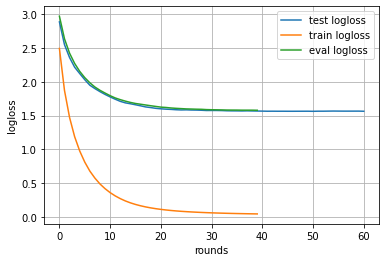

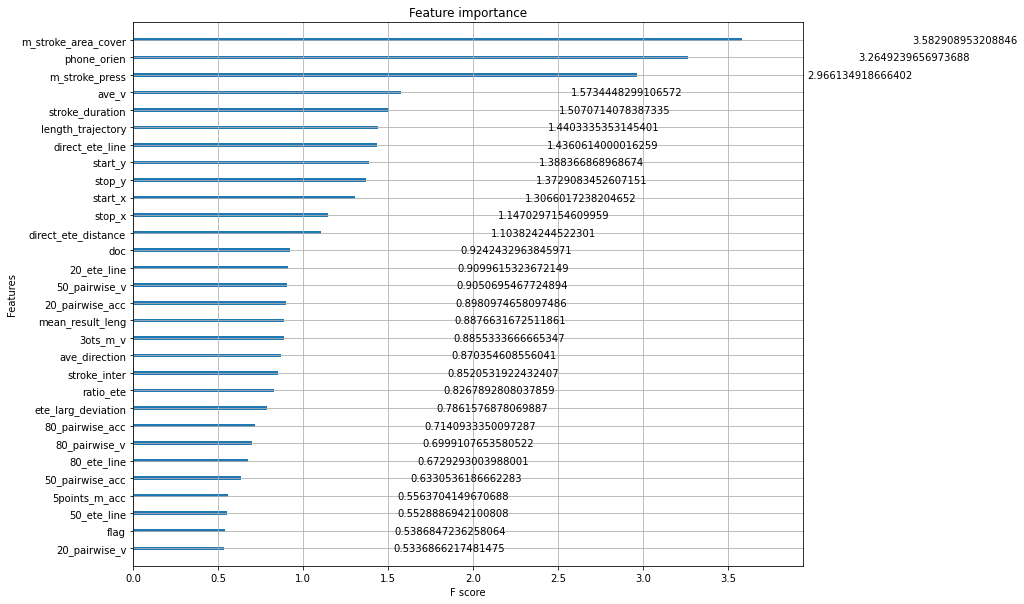

In [66]:
experiment2_50_doc = FeaturesSelect(columns_select1, df_select1, nfold=5)
X_train2_50_doc, X_test2_50_doc, y_train2_50_doc, y_test2_50_doc, matrix2_50_doc, y_pred2_50_doc = experiment2_50_doc.train()

In [67]:
check(X_train2_50_doc, X_test2_50_doc, y_train2_50_doc, y_test2_50_doc, matrix2_50_doc, y_pred2_50_doc)

              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.64      0.70      0.67        10
           2       0.17      0.10      0.12        10
           3       0.69      0.90      0.78        10
           4       0.38      0.30      0.33        10
           5       0.50      0.50      0.50        10
           6       0.44      0.40      0.42        10
           7       0.56      0.50      0.53        10
           8       0.60      0.60      0.60        10
           9       0.55      0.60      0.57        10
          10       0.67      0.60      0.63        10
          11       0.73      0.80      0.76        10
          12       0.56      0.50      0.53        10
          13       0.73      0.80      0.76        10
          14       0.50      0.50      0.50        10
          15       0.33      0.30      0.32        10
          16       0.50      0.70      0.58        10
          17       0.62    

#### docなし

In [68]:
columns_select2 = {'phone', 'finger_orien', 'cd_finger_orien', 'doc'}

Counter({11: 40, 36: 40, 28: 40, 29: 40, 15: 40, 8: 40, 30: 40, 37: 40, 27: 40, 7: 40, 24: 40, 31: 40, 19: 40, 23: 40, 14: 40, 6: 40, 22: 40, 20: 40, 5: 40, 12: 40, 4: 40, 16: 40, 13: 40, 38: 40, 2: 40, 10: 40, 3: 40, 18: 40, 32: 40, 39: 40, 1: 40, 40: 40, 33: 40, 35: 40, 34: 40, 21: 40, 17: 40, 26: 40, 25: 40, 0: 40, 9: 40})
[0]	train-mlogloss:2.41653	eval-mlogloss:2.90316
[10]	train-mlogloss:0.37604	eval-mlogloss:1.81449
[20]	train-mlogloss:0.11577	eval-mlogloss:1.63601
[30]	train-mlogloss:0.05966	eval-mlogloss:1.60787
[40]	train-mlogloss:0.04155	eval-mlogloss:1.60179
[48]	train-mlogloss:0.03453	eval-mlogloss:1.60100
Accuracy : 0.5585365853658537
F1-score : 0.551908141710531
nfold: 5


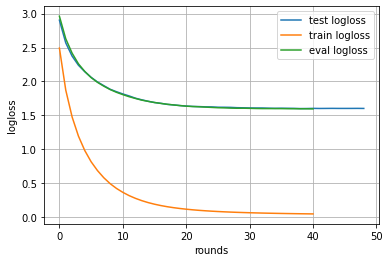

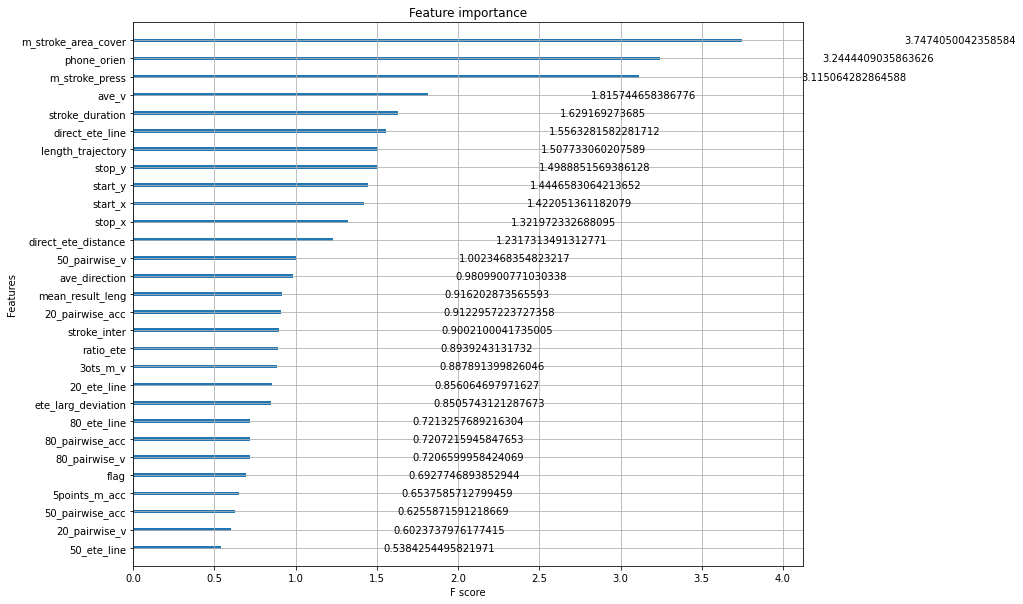

In [69]:
experiment2_50 = FeaturesSelect(columns_select2, df_select1, nfold=5)
X_train2_50, X_test2_50, y_train2_50, y_test2_50, matrix2_50, y_pred2_50 = experiment2_50.train()

In [70]:
check(X_train2_50, X_test2_50, y_train2_50, y_test2_50, matrix2_50, y_pred2_50)

              precision    recall  f1-score   support

           0       0.71      0.50      0.59        10
           1       0.64      0.70      0.67        10
           2       0.14      0.10      0.12        10
           3       0.69      0.90      0.78        10
           4       0.20      0.20      0.20        10
           5       0.36      0.40      0.38        10
           6       0.38      0.30      0.33        10
           7       0.56      0.50      0.53        10
           8       0.67      0.60      0.63        10
           9       0.47      0.70      0.56        10
          10       0.56      0.50      0.53        10
          11       0.73      0.80      0.76        10
          12       0.33      0.20      0.25        10
          13       0.73      0.80      0.76        10
          14       0.44      0.40      0.42        10
          15       0.56      0.50      0.53        10
          16       0.60      0.60      0.60        10
          17       0.62    

#### ストローク方向

In [80]:
# 上下左右のflagをもとにデータを分割
a, b, c, d = flag4(df_dropna, 'flag')
columns_select3 = {'phone', 'finger_orien', 'cd_finger_orien', 'doc'}

In [81]:
df_test1_a = select_data(a, data_num=50)
df_select1_a = df_test1_a.reset_index(drop=True)

In [ ]:
# up
fs50_a = FeaturesSelect(columns_select3, df_select1_a, nfold=5)
X_train_fs50_a, X_test_fs50_a, y_train_fs50_a, y_test_fs50_a, matrix_fs50_a, y_pred_fs50_a = fs50_a.train()

In [ ]:
# left

In [82]:
df_test1_b = select_data(b, data_num=50)
df_select1_b = df_test1_b.reset_index(drop=True)

Counter({4: 40, 39: 40, 18: 40, 28: 40, 26: 40, 16: 40, 19: 40, 37: 40, 22: 40, 32: 40, 8: 40, 13: 40, 40: 40, 5: 40, 14: 40, 17: 40, 31: 40, 27: 40, 12: 40, 7: 40, 1: 40, 34: 40, 15: 40, 10: 40, 6: 40, 0: 40, 20: 40, 38: 40, 11: 40, 3: 40, 24: 40, 2: 40, 21: 40, 36: 40, 23: 40, 9: 40, 35: 40, 30: 40, 33: 21, 25: 20, 29: 19})
[0]	train-mlogloss:2.01888	eval-mlogloss:2.52330
[10]	train-mlogloss:0.25589	eval-mlogloss:1.31921
[20]	train-mlogloss:0.07760	eval-mlogloss:1.16941
[30]	train-mlogloss:0.04288	eval-mlogloss:1.14181
[40]	train-mlogloss:0.03149	eval-mlogloss:1.13140
[50]	train-mlogloss:0.02602	eval-mlogloss:1.12329
[60]	train-mlogloss:0.02291	eval-mlogloss:1.11613
[70]	train-mlogloss:0.02087	eval-mlogloss:1.11420
[80]	train-mlogloss:0.01953	eval-mlogloss:1.11597
[83]	train-mlogloss:0.01922	eval-mlogloss:1.11575
Accuracy : 0.7070707070707071
F1-score : 0.6928821304475219
nfold: 5


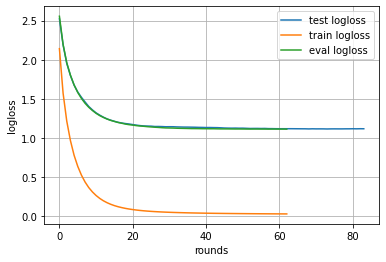

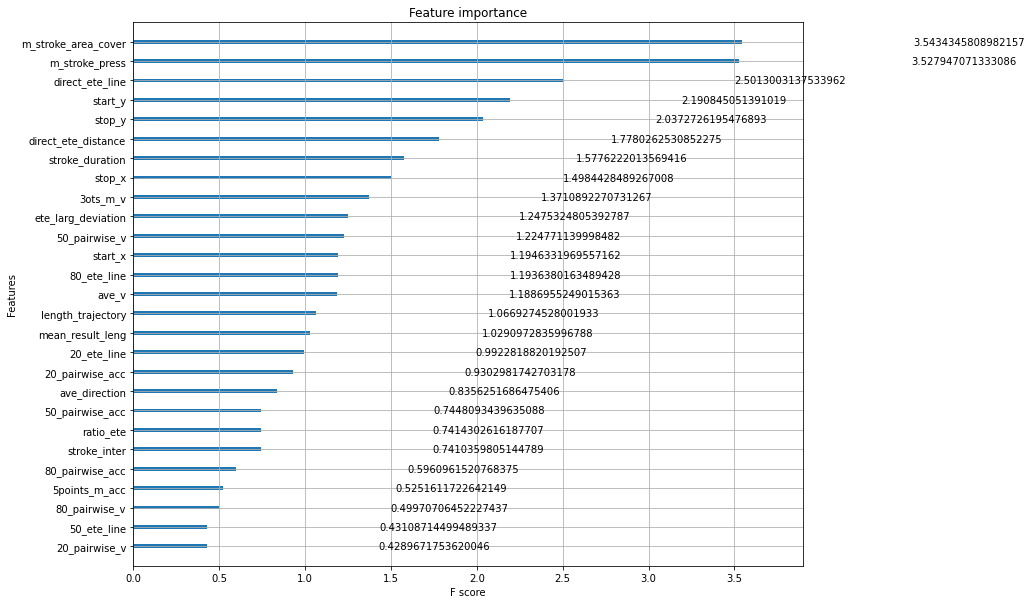

In [83]:
# left
fs50_b = FeaturesSelect(columns_select3, df_select1_b, nfold=5)
X_train_fs50_b, X_test_fs50_b, y_train_fs50_b, y_test_fs50_b, matrix_fs50_b, y_pred_fs50_b = fs50_b.train()


In [84]:
check(X_train_fs50_b, X_test_fs50_b, y_train_fs50_b, y_test_fs50_b, matrix_fs50_b, y_pred_fs50_b)

              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.64      0.70      0.67        10
           2       0.80      0.40      0.53        10
           3       0.80      0.80      0.80        10
           4       0.78      0.70      0.74        10
           5       0.73      0.80      0.76        10
           6       0.64      0.70      0.67        10
           7       0.36      0.50      0.42        10
           8       0.80      0.80      0.80        10
           9       0.70      0.70      0.70        10
          10       0.70      0.70      0.70        10
          11       0.91      1.00      0.95        10
          12       0.78      0.70      0.74        10
          13       0.86      0.60      0.71        10
          14       0.80      0.80      0.80        10
          15       0.71      0.50      0.59        10
          16       0.50      0.40      0.44        10
          17       0.88    

In [ ]:
# down

In [85]:
df_test1_c = select_data(c, data_num=50)
df_select1_c = df_test1_c.reset_index(drop=True)

Counter({11: 40, 36: 40, 28: 40, 29: 40, 15: 40, 8: 40, 30: 40, 37: 40, 27: 40, 7: 40, 24: 40, 31: 40, 19: 40, 23: 40, 14: 40, 6: 40, 22: 40, 20: 40, 5: 40, 12: 40, 4: 40, 16: 40, 13: 40, 38: 40, 2: 40, 10: 40, 3: 40, 18: 40, 32: 40, 39: 40, 1: 40, 40: 40, 33: 40, 35: 40, 34: 40, 21: 40, 17: 40, 26: 40, 25: 40, 0: 40, 9: 40})
[0]	train-mlogloss:2.08700	eval-mlogloss:2.64391
[10]	train-mlogloss:0.28094	eval-mlogloss:1.38993
[20]	train-mlogloss:0.08505	eval-mlogloss:1.22534
[30]	train-mlogloss:0.04584	eval-mlogloss:1.18826
[40]	train-mlogloss:0.03306	eval-mlogloss:1.17807
[50]	train-mlogloss:0.02697	eval-mlogloss:1.17291
[60]	train-mlogloss:0.02355	eval-mlogloss:1.17591
[64]	train-mlogloss:0.02254	eval-mlogloss:1.17445
Accuracy : 0.6829268292682927
F1-score : 0.6802194780469603
nfold: 5


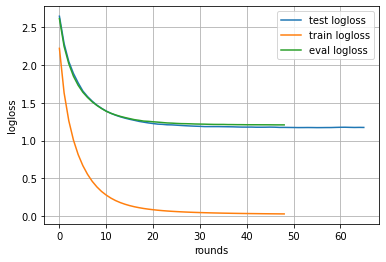

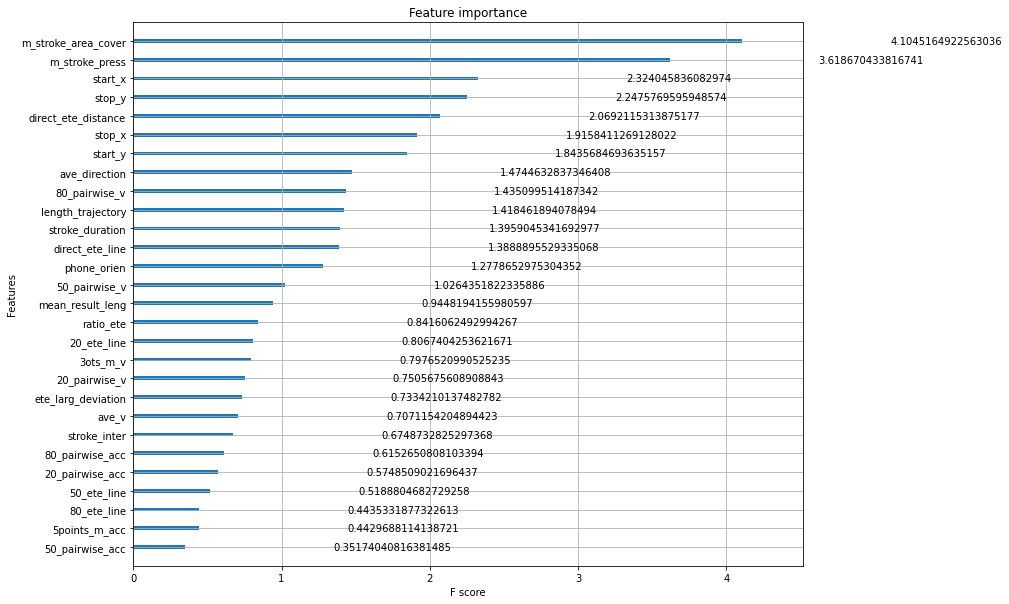

In [86]:
# down
fs50_c = FeaturesSelect(columns_select3, df_select1_c, nfold=5)
X_train_fs50_c, X_test_fs50_c, y_train_fs50_c, y_test_fs50_c, matrix_fs50_c, y_pred_fs50_c = fs50_c.train()


In [87]:
check(X_train_fs50_c, X_test_fs50_c, y_train_fs50_c, y_test_fs50_c, matrix_fs50_c, y_pred_fs50_c)

              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.88      0.70      0.78        10
           2       0.50      0.30      0.37        10
           3       0.82      0.90      0.86        10
           4       0.36      0.40      0.38        10
           5       0.56      0.50      0.53        10
           6       0.55      0.60      0.57        10
           7       0.67      0.60      0.63        10
           8       0.80      0.80      0.80        10
           9       0.38      0.30      0.33        10
          10       0.43      0.60      0.50        10
          11       0.75      0.60      0.67        10
          12       0.42      0.50      0.45        10
          13       0.73      0.80      0.76        10
          14       0.80      0.80      0.80        10
          15       0.40      0.40      0.40        10
          16       0.58      0.70      0.64        10
          17       0.50    

In [ ]:
# right

In [88]:
df_test1_d = select_data(d, data_num=50)
df_select1_d = df_test1_d.reset_index(drop=True)

Counter({15: 40, 2: 40, 31: 40, 21: 40, 34: 40, 12: 40, 5: 40, 38: 40, 35: 40, 40: 40, 1: 40, 36: 40, 7: 40, 37: 40, 27: 40, 8: 40, 30: 40, 24: 40, 6: 40, 17: 40, 10: 40, 3: 40, 4: 40, 19: 40, 0: 40, 11: 40, 28: 40, 39: 40, 23: 40, 16: 40, 13: 40, 32: 40, 18: 40, 14: 40, 22: 40, 9: 40, 20: 40, 26: 40, 25: 28, 33: 24, 29: 20})
[0]	train-mlogloss:1.98635	eval-mlogloss:2.39746
[10]	train-mlogloss:0.26589	eval-mlogloss:1.28373
[20]	train-mlogloss:0.08007	eval-mlogloss:1.15343
[30]	train-mlogloss:0.04392	eval-mlogloss:1.11499
[40]	train-mlogloss:0.03212	eval-mlogloss:1.09855
[50]	train-mlogloss:0.02650	eval-mlogloss:1.09164
[60]	train-mlogloss:0.02330	eval-mlogloss:1.09042
[66]	train-mlogloss:0.02195	eval-mlogloss:1.09103
Accuracy : 0.7117794486215538
F1-score : 0.7035311788183691
nfold: 5


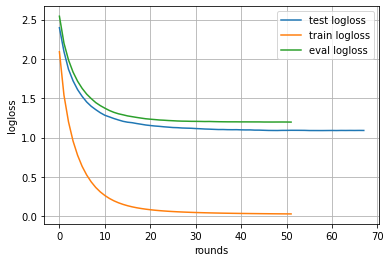

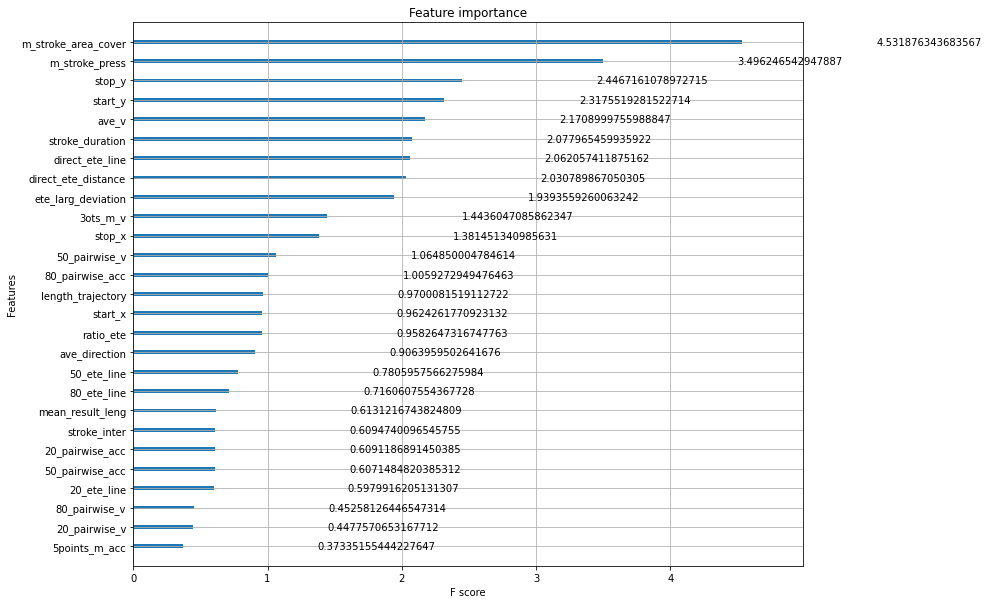

In [89]:
# right
fs50_d = FeaturesSelect(columns_select3, df_select1_d, nfold=5)
X_train_fs50_d, X_test_fs50_d, y_train_fs50_d, y_test_fs50_d, matrix_fs50_d, y_pred_fs50_d = fs50_d.train()


In [90]:
check(X_train_fs50_d, X_test_fs50_d, y_train_fs50_d, y_test_fs50_d, matrix_fs50_d, y_pred_fs50_d)

              precision    recall  f1-score   support

           0       0.75      0.90      0.82        10
           1       0.54      0.70      0.61        10
           2       0.67      0.40      0.50        10
           3       0.69      0.90      0.78        10
           4       0.67      0.60      0.63        10
           5       0.67      0.40      0.50        10
           6       0.57      0.80      0.67        10
           7       0.88      0.70      0.78        10
           8       0.77      1.00      0.87        10
           9       0.70      0.70      0.70        10
          10       0.45      0.50      0.48        10
          11       0.83      1.00      0.91        10
          12       0.55      0.60      0.57        10
          13       0.82      0.90      0.86        10
          14       0.77      1.00      0.87        10
          15       0.64      0.70      0.67        10
          16       0.36      0.40      0.38        10
          17       0.69    

### 2ストローク

In [71]:
# 2ストローク
df_test2 = select_data(df_ori_t1, data_num=50)
df_select2 = df_test2.reset_index(drop=True)
df_select2.shape

(2050, 111)

In [ ]:
# docなし
columns_select_mf3 = {'Unnamed: 0', 'flag', 'finger_orien', 'cd_finger_orien', 'doc',
                     'user2', 'doc2', 'flag2', 'finger_orien2', 'cd_finger_orien2',
                     'user_ave', 'doc_ave', 'flag_ave', 'finger_orien_ave', 'cd_finger_orien_ave',
                     'phone_orien_ave', 'stroke_inter_ave', 'stroke_duration_ave', 'start_x_ave', 'start_y_ave',
                     'stop_x_ave', 'stop_y_ave', 'direct_ete_distance_ave', 'mean_result_leng_ave',
                     'direct_ete_line_ave', '20_pairwise_v_ave', '50_pairwise_v_ave', '80_pairwise_v_ave',
                     '20_pairwise_acc_ave', '50_pairwise_acc_ave', '80_pairwise_acc_ave', '3ots_m_v_ave',
                     'ete_larg_deviation_ave', '20_ete_line_ave', '50_ete_line_ave', '80_ete_line_ave',
                     'ave_direction_ave', 'length_trajectory_ave', 'ratio_ete_ave', 'ave_v_ave',
                     '5points_m_acc_ave', 'm_stroke_press_ave', 'm_stroke_area_cover_ave'}

In [ ]:
# docあり
columns_select_mf2 = {'Unnamed: 0', 'flag', 'finger_orien', 'cd_finger_orien',
                     'user2', 'doc2', 'flag2', 'finger_orien2', 'cd_finger_orien2',
                     'user_ave', 'doc_ave', 'flag_ave', 'finger_orien_ave', 'cd_finger_orien_ave',
                     'phone_orien_ave', 'stroke_inter_ave', 'stroke_duration_ave', 'start_x_ave', 'start_y_ave',
                     'stop_x_ave', 'stop_y_ave', 'direct_ete_distance_ave', 'mean_result_leng_ave',
                     'direct_ete_line_ave', '20_pairwise_v_ave', '50_pairwise_v_ave', '80_pairwise_v_ave',
                     '20_pairwise_acc_ave', '50_pairwise_acc_ave', '80_pairwise_acc_ave', '3ots_m_v_ave',
                     'ete_larg_deviation_ave', '20_ete_line_ave', '50_ete_line_ave', '80_ete_line_ave',
                     'ave_direction_ave', 'length_trajectory_ave', 'ratio_ete_ave', 'ave_v_ave',
                     '5points_m_acc_ave', 'm_stroke_press_ave', 'm_stroke_area_cover_ave'}

#### docなし

Counter({11: 40, 36: 40, 28: 40, 29: 40, 15: 40, 8: 40, 30: 40, 37: 40, 27: 40, 7: 40, 24: 40, 31: 40, 19: 40, 23: 40, 14: 40, 6: 40, 22: 40, 20: 40, 5: 40, 12: 40, 4: 40, 16: 40, 13: 40, 38: 40, 2: 40, 10: 40, 3: 40, 18: 40, 32: 40, 39: 40, 1: 40, 40: 40, 33: 40, 35: 40, 34: 40, 21: 40, 17: 40, 26: 40, 25: 40, 0: 40, 9: 40})
[0]	train-mlogloss:2.36473	eval-mlogloss:2.89358
[10]	train-mlogloss:0.29258	eval-mlogloss:1.63815
[20]	train-mlogloss:0.08373	eval-mlogloss:1.43838
[30]	train-mlogloss:0.04401	eval-mlogloss:1.37679
[40]	train-mlogloss:0.03122	eval-mlogloss:1.34713
[50]	train-mlogloss:0.02536	eval-mlogloss:1.33192
[60]	train-mlogloss:0.02221	eval-mlogloss:1.32753
[70]	train-mlogloss:0.02018	eval-mlogloss:1.32273
[80]	train-mlogloss:0.01873	eval-mlogloss:1.32151
[82]	train-mlogloss:0.01847	eval-mlogloss:1.32188
Accuracy : 0.6170731707317073
F1-score : 0.6196229056759476
nfold: 5


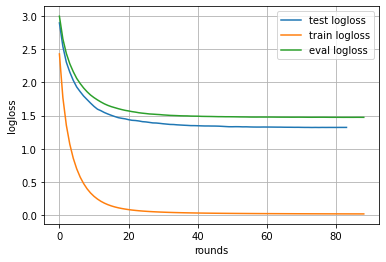

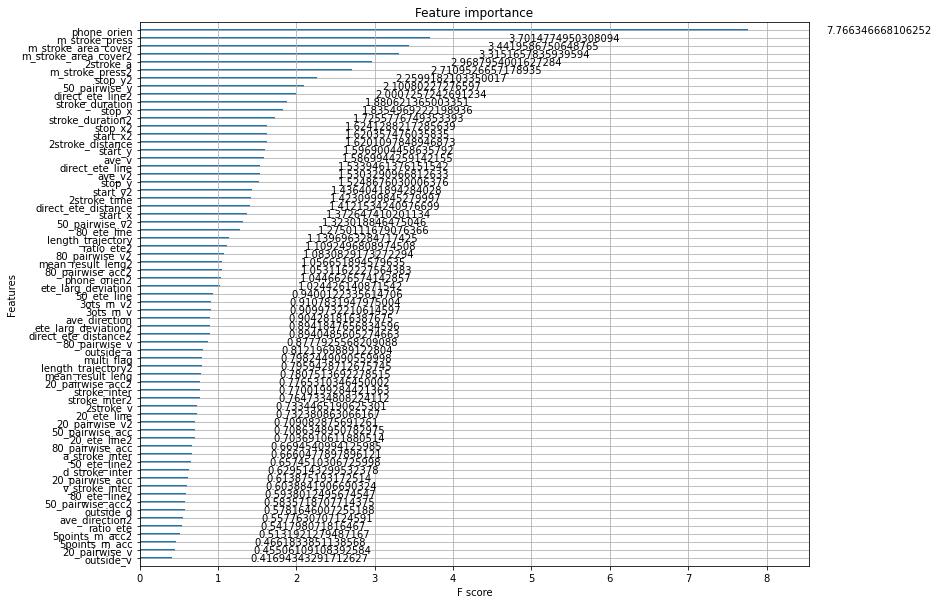

In [72]:
experiment_mf_doc = FeaturesSelect(columns_select_mf3, df_select2, nfold=5)
X_train_mf_doc, X_test_mf_doc, y_train_mf_doc, y_test_mf_doc, matrix_mf_doc, y_pred_mf_doc = experiment_mf_doc.train()

In [73]:
check(X_train_mf_doc, X_test_mf_doc, y_train_mf_doc, y_test_mf_doc, matrix_mf_doc, y_pred_mf_doc)

              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.64      0.70      0.67        10
           2       0.40      0.40      0.40        10
           3       0.50      0.50      0.50        10
           4       0.71      0.50      0.59        10
           5       0.83      0.50      0.62        10
           6       0.57      0.40      0.47        10
           7       0.80      0.80      0.80        10
           8       0.75      0.60      0.67        10
           9       0.57      0.40      0.47        10
          10       0.50      0.40      0.44        10
          11       1.00      0.80      0.89        10
          12       0.40      0.40      0.40        10
          13       0.54      0.70      0.61        10
          14       0.90      0.90      0.90        10
          15       0.41      0.70      0.52        10
          16       0.38      0.30      0.33        10
          17       0.35    

#### docあり

Counter({11: 40, 36: 40, 28: 40, 29: 40, 15: 40, 8: 40, 30: 40, 37: 40, 27: 40, 7: 40, 24: 40, 31: 40, 19: 40, 23: 40, 14: 40, 6: 40, 22: 40, 20: 40, 5: 40, 12: 40, 4: 40, 16: 40, 13: 40, 38: 40, 2: 40, 10: 40, 3: 40, 18: 40, 32: 40, 39: 40, 1: 40, 40: 40, 33: 40, 35: 40, 34: 40, 21: 40, 17: 40, 26: 40, 25: 40, 0: 40, 9: 40})
[0]	train-mlogloss:2.36134	eval-mlogloss:2.88930
[10]	train-mlogloss:0.29290	eval-mlogloss:1.63591
[20]	train-mlogloss:0.08410	eval-mlogloss:1.43746
[30]	train-mlogloss:0.04396	eval-mlogloss:1.37139
[40]	train-mlogloss:0.03109	eval-mlogloss:1.34484
[50]	train-mlogloss:0.02530	eval-mlogloss:1.33743
[60]	train-mlogloss:0.02211	eval-mlogloss:1.33184
[70]	train-mlogloss:0.02008	eval-mlogloss:1.32782
[80]	train-mlogloss:0.01864	eval-mlogloss:1.32719
[84]	train-mlogloss:0.01819	eval-mlogloss:1.32804
Accuracy : 0.6121951219512195
F1-score : 0.6159008146973898
nfold: 5


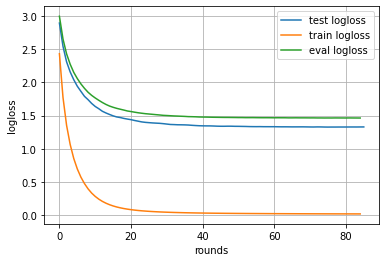

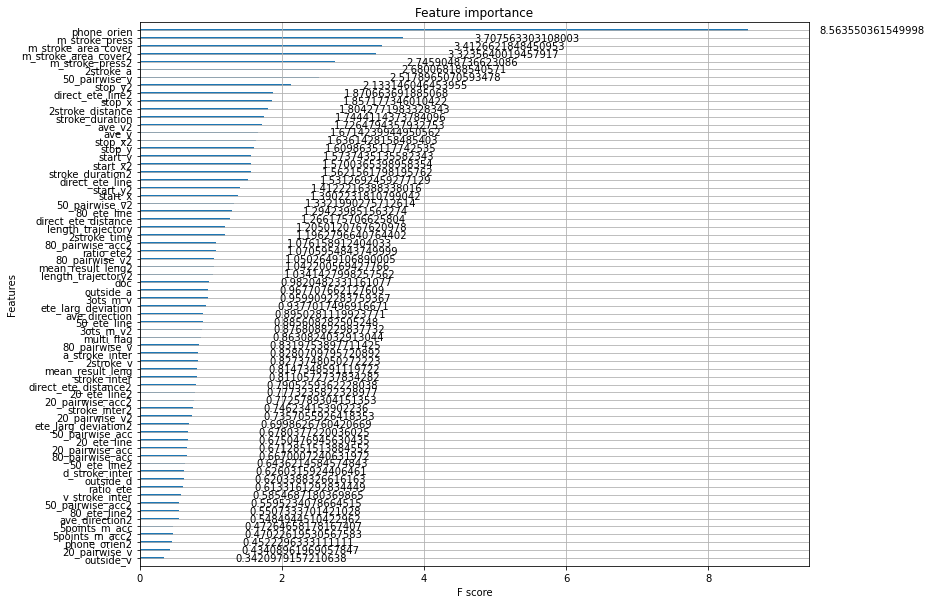

In [74]:
experiment_mf_docf = FeaturesSelect(columns_select_mf2, df_select2, nfold=5)
X_train_mf_docf, X_test_mf_docf, y_train_mf_docf, y_test_mf_docf, matrix_mf_docf, y_pred_mf_docf = experiment_mf_docf.train()

In [75]:
check(X_train_mf_docf, X_test_mf_docf, y_train_mf_docf, y_test_mf_docf, matrix_mf_docf, y_pred_mf_docf)

              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.64      0.70      0.67        10
           2       0.33      0.30      0.32        10
           3       0.56      0.50      0.53        10
           4       0.56      0.50      0.53        10
           5       0.62      0.50      0.56        10
           6       0.50      0.60      0.55        10
           7       0.89      0.80      0.84        10
           8       0.78      0.70      0.74        10
           9       0.67      0.40      0.50        10
          10       0.43      0.30      0.35        10
          11       1.00      0.80      0.89        10
          12       0.33      0.30      0.32        10
          13       0.57      0.80      0.67        10
          14       0.90      0.90      0.90        10
          15       0.35      0.70      0.47        10
          16       0.57      0.40      0.47        10
          17       0.31    

#### ストローク方向

In [96]:
# 上下左右のflagをもとにデータを分割
aa, ab, ac, ad, ba, bb, bc, bd, ca, cb, cc, cd, da, db, dc, dd = flag16(df_ori_t1, 'multi_flag')
# experiment_mf3を使用
# cc.shape

df_test2_cc = select_data(cc, data_num=50)
df_select2_cc = df_test2_cc.reset_index(drop=True)
df_select2_cc.shape

(2050, 110)

Counter({11: 40, 36: 40, 28: 40, 29: 40, 15: 40, 8: 40, 30: 40, 37: 40, 27: 40, 7: 40, 24: 40, 31: 40, 19: 40, 23: 40, 14: 40, 6: 40, 22: 40, 20: 40, 5: 40, 12: 40, 4: 40, 16: 40, 13: 40, 38: 40, 2: 40, 10: 40, 3: 40, 18: 40, 32: 40, 39: 40, 1: 40, 40: 40, 33: 40, 35: 40, 34: 40, 21: 40, 17: 40, 26: 40, 25: 40, 0: 40, 9: 40})
[0]	train-mlogloss:2.03921	eval-mlogloss:2.56500
[10]	train-mlogloss:0.20930	eval-mlogloss:1.18217
[20]	train-mlogloss:0.05995	eval-mlogloss:0.97501
[30]	train-mlogloss:0.03274	eval-mlogloss:0.92025
[40]	train-mlogloss:0.02396	eval-mlogloss:0.89897
[50]	train-mlogloss:0.02006	eval-mlogloss:0.89265
[60]	train-mlogloss:0.01785	eval-mlogloss:0.88621
[70]	train-mlogloss:0.01647	eval-mlogloss:0.88431
[73]	train-mlogloss:0.01616	eval-mlogloss:0.88422
Accuracy : 0.7365853658536585
F1-score : 0.7310973822520529
nfold: 5


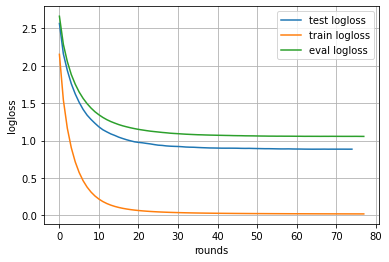

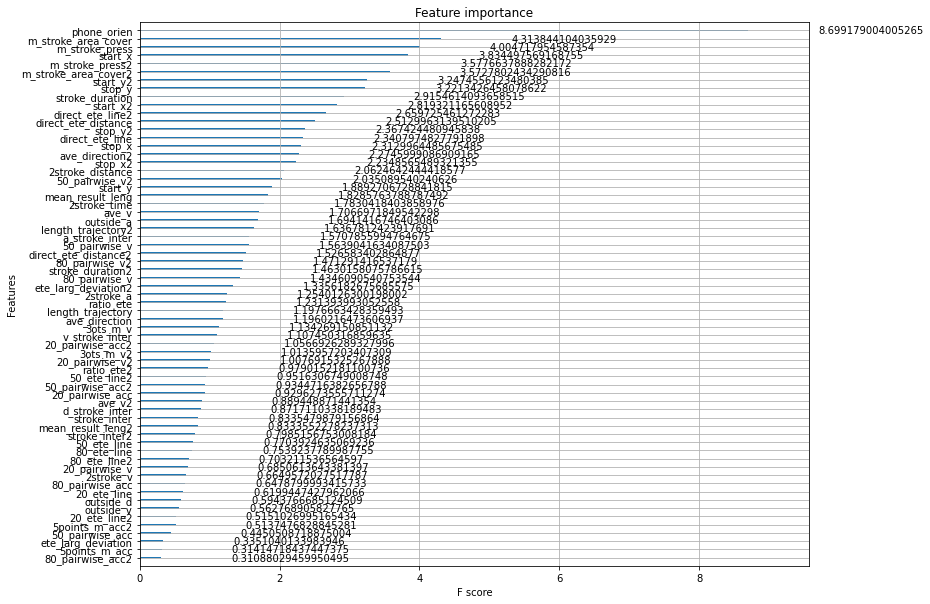

In [97]:
experiment_mf_doc_cc = FeaturesSelect(columns_select_mf3, df_select2_cc, nfold=5)
X_train_mf_doc_cc, X_test_mf_doc_cc, y_train_mf_doc_cc, y_test_mf_doc_cc, matrix_mf_doc_cc, y_pred_mf_doc_cc = experiment_mf_doc_cc.train()


In [98]:
check(X_train_mf_doc_cc, X_test_mf_doc_cc, y_train_mf_doc_cc, y_test_mf_doc_cc, matrix_mf_doc_cc, y_pred_mf_doc_cc)

              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.82      0.90      0.86        10
           2       0.50      0.30      0.37        10
           3       0.90      0.90      0.90        10
           4       0.38      0.30      0.33        10
           5       0.64      0.70      0.67        10
           6       0.80      0.80      0.80        10
           7       0.73      0.80      0.76        10
           8       0.71      1.00      0.83        10
           9       0.75      0.60      0.67        10
          10       0.55      0.60      0.57        10
          11       0.88      0.70      0.78        10
          12       0.69      0.90      0.78        10
          13       0.75      0.90      0.82        10
          14       0.83      1.00      0.91        10
          15       0.36      0.40      0.38        10
          16       0.78      0.70      0.74        10
          17       0.83    

#### add_featuresなし

In [91]:
# docなし
# add_featuresなし
columns_select_mf4 = {'Unnamed: 0', 'flag', 'finger_orien', 'cd_finger_orien', 'doc',
                     'user2', 'doc2', 'flag2', 'finger_orien2', 'cd_finger_orien2',
                     'user_ave', 'doc_ave', 'flag_ave', 'finger_orien_ave', 'cd_finger_orien_ave',
                     'phone_orien_ave', 'stroke_inter_ave', 'stroke_duration_ave', 'start_x_ave', 'start_y_ave',
                     'stop_x_ave', 'stop_y_ave', 'direct_ete_distance_ave', 'mean_result_leng_ave',
                     'direct_ete_line_ave', '20_pairwise_v_ave', '50_pairwise_v_ave', '80_pairwise_v_ave',
                     '20_pairwise_acc_ave', '50_pairwise_acc_ave', '80_pairwise_acc_ave', '3ots_m_v_ave',
                     'ete_larg_deviation_ave', '20_ete_line_ave', '50_ete_line_ave', '80_ete_line_ave',
                     'ave_direction_ave', 'length_trajectory_ave', 'ratio_ete_ave', 'ave_v_ave',
                     '5points_m_acc_ave', 'm_stroke_press_ave', 'm_stroke_area_cover_ave',
                     '2stroke_a', '2stroke_distance', '2stroke_time', '2stroke_v', 'a_stroke_inter', 
                     'd_stroke_inter', 'outside_a', 'outside_d', 'outside_v', 'v_stroke_inter'}

Counter({11: 40, 36: 40, 28: 40, 29: 40, 15: 40, 8: 40, 30: 40, 37: 40, 27: 40, 7: 40, 24: 40, 31: 40, 19: 40, 23: 40, 14: 40, 6: 40, 22: 40, 20: 40, 5: 40, 12: 40, 4: 40, 16: 40, 13: 40, 38: 40, 2: 40, 10: 40, 3: 40, 18: 40, 32: 40, 39: 40, 1: 40, 40: 40, 33: 40, 35: 40, 34: 40, 21: 40, 17: 40, 26: 40, 25: 40, 0: 40, 9: 40})
[0]	train-mlogloss:2.35538	eval-mlogloss:2.90676
[10]	train-mlogloss:0.29537	eval-mlogloss:1.64870
[20]	train-mlogloss:0.08619	eval-mlogloss:1.45411
[30]	train-mlogloss:0.04495	eval-mlogloss:1.38654
[40]	train-mlogloss:0.03179	eval-mlogloss:1.35863
[50]	train-mlogloss:0.02580	eval-mlogloss:1.34742
[60]	train-mlogloss:0.02258	eval-mlogloss:1.34046
[70]	train-mlogloss:0.02046	eval-mlogloss:1.33609
[80]	train-mlogloss:0.01900	eval-mlogloss:1.33601
[90]	train-mlogloss:0.01792	eval-mlogloss:1.33724
Accuracy : 0.6073170731707317
F1-score : 0.6073078116196537
nfold: 5


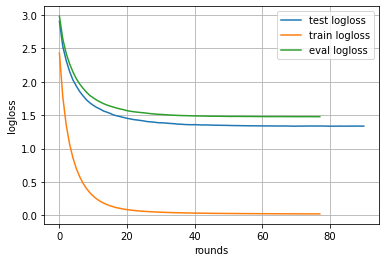

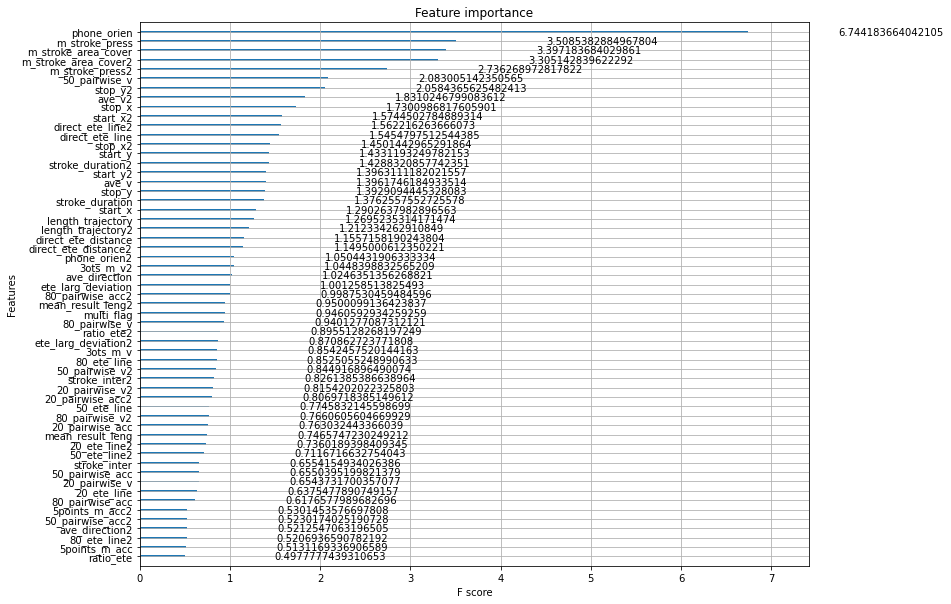

In [92]:
experiment_mf_docf4 = FeaturesSelect(columns_select_mf4, df_select2, nfold=5)
X_train_mf_docf4, X_test_mf_docf4, y_train_mf_docf4, y_test_mf_docf4, matrix_mf_docf4, y_pred_mf_docf4 = experiment_mf_docf4.train()


In [93]:
check(X_train_mf_docf4, X_test_mf_docf4, y_train_mf_docf4, y_test_mf_docf4, matrix_mf_docf4, y_pred_mf_docf4)

              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.64      0.70      0.67        10
           2       0.57      0.40      0.47        10
           3       0.44      0.40      0.42        10
           4       0.50      0.40      0.44        10
           5       0.50      0.40      0.44        10
           6       0.45      0.50      0.48        10
           7       0.57      0.40      0.47        10
           8       0.70      0.70      0.70        10
           9       0.57      0.40      0.47        10
          10       0.27      0.30      0.29        10
          11       1.00      0.80      0.89        10
          12       0.43      0.60      0.50        10
          13       0.55      0.60      0.57        10
          14       0.89      0.80      0.84        10
          15       0.37      0.70      0.48        10
          16       0.50      0.50      0.50        10
          17       0.42    

## 特徴量を減らす
docはなし

### 実験プログラム(特徴量削減)

In [47]:
class FeaturesExcept():
    def __init__(self, columns_select, df_dropna, nfold):
        '''
        columns_select: 削除するカラム名
        df_dropna: データセット(欠損値処理済み)
        nfold: k分割交差検証におけるkの指定
        '''
        self.columns_select = columns_select
        df_dropna1 = df_dropna.copy()
        df_drop1 = df_dropna1.drop(columns_select, axis=1)
        self.df_drop = df_drop1
        self.nfold = nfold
    
    def train(self):
        df = self.df_drop.copy()
        
        df1 = df.copy()
        df1["user"] = df1["user"]-1
        
        # 教師データの作成
        y = df1.user
        X = df1.drop("user", 1)
        
#         X = X1[]

        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.2,
                                                            shuffle=True,
                                                            random_state=0,
                                                            stratify=y)
        

        # 可視化のために特徴量の名前を渡しておく
        dtrain = xgb.DMatrix(X_train, label=y_train,
                             feature_names=df.columns[1:], silent=1)
        dtest = xgb.DMatrix(X_test, label=y_test,
                            feature_names=df.columns[1:], silent=1)

        print(collections.Counter(y_train))

        eval_metric = 'mlogloss'
        num_class = 41

        xgb_params = {
            # 多値分類問題
            'objective': 'multi:softmax',
            # クラス数
            'num_class': num_class,
            # 学習用の指標 (Multiclass logloss)
            'eval_metric': eval_metric,
        }

        # 交差検証する
        history = xgb.cv(xgb_params,
                         dtrain,
                         num_boost_round=1000,
                         early_stopping_rounds=10,
                         nfold=self.nfold,
                         # 層化分割する
                         stratified=True,
                         # 検証の経過を出力する
                         verbose_eval=10,
                         )

        # 学習時に用いる検証用データ
        evals = [(dtrain, 'train'), (dtest, 'eval')]

        # 学習過程を記録するための辞書
        evals_result = {}
        bst = xgb.train(xgb_params,
                        dtrain,
                        num_boost_round=1000,  # ラウンド数を増やしておく
                        early_stopping_rounds=10,
                        evals=evals,
                        evals_result=evals_result,
                        verbose_eval=10,
                        )

        y_pred = bst.predict(dtest)
        acc = accuracy_score(y_test, y_pred)
        f1score = f1_score(y_test, y_pred, average=None)
        print(f'Accuracy :', acc)
        print(f'F1-score :', f1score.mean())
        self.fimportance = bst.get_fscore()
        self.f1score = f1score
#         print(self.fimportance)
        self.bst = bst

        # 混同行列の計算
        df_accuracy = pd.DataFrame({'va_y': y_test,
                                'y_pred_max': y_pred})
        matrix = pd.crosstab(df_accuracy['va_y'], df_accuracy['y_pred_max'])

        print(f'nfold: {self.nfold}')
        # 学習の課程を折れ線グラフとしてプロットする
        test_metric = evals_result['eval'][eval_metric]
        plt.plot(test_metric, label='test logloss')
        train_metric = history['train-mlogloss-mean']
        plt.plot(train_metric, label='train logloss')
        eval_metric = history['test-mlogloss-mean']
        plt.plot(eval_metric, label='eval logloss')
        plt.grid()
        plt.legend()
        plt.xlabel('rounds')
        plt.ylabel('logloss')
        plt.show()
        

        

        def plot2(bst):
            # 性能向上に寄与する度合いで重要度をプロットする
            _, ax = plt.subplots(figsize=(12, 10))
            xgb.plot_importance(bst,
                                ax=ax,
                                importance_type='gain',
                                show_values=True)
            plt.show()

        plot2(self.bst)
        
#         self.fimportance = bst.get_fscore()
        
        return X_train, X_test, y_train, y_test, matrix, y_pred


### 1ストローク

In [3]:
columns_select2 = {'phone', 'finger_orien', 'cd_finger_orien', 'doc'}

In [ ]:
feature_importance1 = ['phone_orien', 'm_stroke_area_cover',
                       'm_stroke_press', 'direct_ete_line',
                       'start_x', 'stop_x', 'length_trajectory',
                       'stroke_duration', 'start_y', 'ave_v', 'stop_y',
                       'flag', '80_pairwise_v', 'ave_direction',
                       'direct_ete_distance', 'mean_result_leng',
                       'stroke_inter', 'ete_larg_deviation',
                       '3ots_m_v', '20_ete_line', '20_pairwise_acc',
                       '80_ete_line', '50_pairwise_v', '20_pairwise_v',
                       'ratio_ete', '50_ete_line', '80_pairwise_acc',
                       '5points_m_acc', '50_pairwise_acc']

Counter({1: 970, 34: 849, 22: 750, 37: 623, 2: 606, 16: 564, 20: 560, 27: 558, 32: 547, 14: 536, 13: 518, 7: 492, 26: 486, 33: 486, 6: 467, 5: 448, 35: 394, 17: 367, 8: 361, 10: 355, 28: 344, 38: 343, 23: 343, 36: 338, 4: 329, 24: 328, 9: 308, 15: 304, 0: 304, 21: 295, 30: 294, 19: 283, 11: 273, 39: 248, 12: 244, 31: 242, 18: 234, 25: 182, 3: 181, 29: 178, 40: 146})
[0]	train-mlogloss:1.90071	eval-mlogloss:2.12770
[10]	train-mlogloss:0.61407	eval-mlogloss:1.11133
[20]	train-mlogloss:0.32610	eval-mlogloss:0.91686
[30]	train-mlogloss:0.18498	eval-mlogloss:0.84310
[40]	train-mlogloss:0.10966	eval-mlogloss:0.80805
[50]	train-mlogloss:0.06894	eval-mlogloss:0.78534
[60]	train-mlogloss:0.04516	eval-mlogloss:0.77158
[70]	train-mlogloss:0.03228	eval-mlogloss:0.76444
[80]	train-mlogloss:0.02388	eval-mlogloss:0.75745
[90]	train-mlogloss:0.01854	eval-mlogloss:0.75840
Accuracy : 0.7839328537170264
F1-score : 0.7649683846785383
nfold: 5


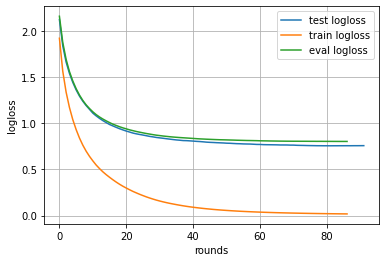

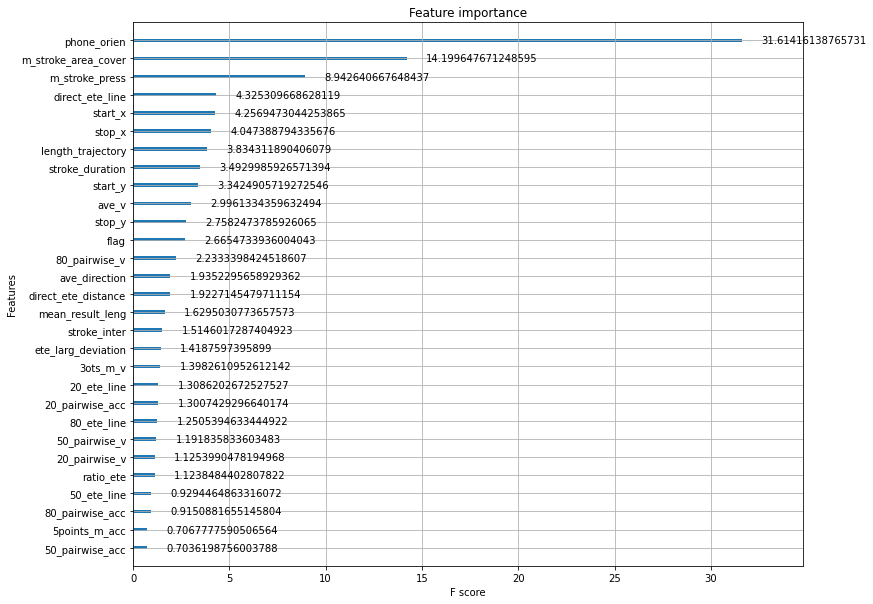

In [24]:
fx1 = FeaturesExcept(columns_select2, df_dropna, nfold=5)
X_train_fx1, X_test_fx1, y_train_fx1, y_test_fx1, matrix_fx1, y_pred_fx1 = fx1.train()
# check(X_train2, X_test2, y_train2, y_test2, matrix2, y_pred2)

In [14]:
fx1.bst.get_fscore()

AttributeError: 'FeaturesExcept' object has no attribute 'bst'

In [ ]:
fxfi1 = fx1.fimportance

fxlist1 = []

for mykey in fxfi1.keys():
    fxlist.append(mykey)

fxlist

### 2ストローク

In [ ]:
# docなし
columns_select_mf3 = {'Unnamed: 0', 'flag', 'finger_orien', 'cd_finger_orien', 'doc',
                     'user2', 'doc2', 'flag2', 'finger_orien2', 'cd_finger_orien2',
                     'user_ave', 'doc_ave', 'flag_ave', 'finger_orien_ave', 'cd_finger_orien_ave',
                     'phone_orien_ave', 'stroke_inter_ave', 'stroke_duration_ave', 'start_x_ave', 'start_y_ave',
                     'stop_x_ave', 'stop_y_ave', 'direct_ete_distance_ave', 'mean_result_leng_ave',
                     'direct_ete_line_ave', '20_pairwise_v_ave', '50_pairwise_v_ave', '80_pairwise_v_ave',
                     '20_pairwise_acc_ave', '50_pairwise_acc_ave', '80_pairwise_acc_ave', '3ots_m_v_ave',
                     'ete_larg_deviation_ave', '20_ete_line_ave', '50_ete_line_ave', '80_ete_line_ave',
                     'ave_direction_ave', 'length_trajectory_ave', 'ratio_ete_ave', 'ave_v_ave',
                     '5points_m_acc_ave', 'm_stroke_press_ave', 'm_stroke_area_cover_ave'}

In [ ]:
feature_importance2 = ['phone_orien''m_stroke_area_cover','m_stroke_area_cover2',
                       'm_stroke_press', 'm_stroke_press2',
                       'length_trajectory', 'direct_ete_line',
                       'start_y', 'start_x', 'ave_v2', '50_pairwise_v2',
                       '2stroke_distance', 'stroke_duration2', 'stroke_duration',
                       'ave_v', '80_pairwise_v', 'start_y2', ''
                       ]

In [ ]:
fx2 = FeaturesExcept(columns_select_mf3, df_select2, nfold=5)
X_train_fx2, X_test_fx2, y_train_fx2, y_test_fx2, matrix_fx2, y_pred_fx2 = fx2.train()

## おまけ

In [ ]:
# データはすべて利用

In [48]:
# docなし
# add_featuresなし
columns_select_mf4 = {'Unnamed: 0', 'flag', 'finger_orien', 'cd_finger_orien', 'doc',
                     'user2', 'doc2', 'flag2', 'finger_orien2', 'cd_finger_orien2',
                     'user_ave', 'doc_ave', 'flag_ave', 'finger_orien_ave', 'cd_finger_orien_ave',
                     'phone_orien_ave', 'stroke_inter_ave', 'stroke_duration_ave', 'start_x_ave', 'start_y_ave',
                     'stop_x_ave', 'stop_y_ave', 'direct_ete_distance_ave', 'mean_result_leng_ave',
                     'direct_ete_line_ave', '20_pairwise_v_ave', '50_pairwise_v_ave', '80_pairwise_v_ave',
                     '20_pairwise_acc_ave', '50_pairwise_acc_ave', '80_pairwise_acc_ave', '3ots_m_v_ave',
                     'ete_larg_deviation_ave', '20_ete_line_ave', '50_ete_line_ave', '80_ete_line_ave',
                     'ave_direction_ave', 'length_trajectory_ave', 'ratio_ete_ave', 'ave_v_ave',
                     '5points_m_acc_ave', 'm_stroke_press_ave', 'm_stroke_area_cover_ave',
                     '2stroke_a', '2stroke_distance', '2stroke_time', '2stroke_v', 'a_stroke_inter', 
                     'd_stroke_inter', 'outside_a', 'outside_d', 'outside_v', 'v_stroke_inter'}

Counter({1: 954, 34: 842, 22: 726, 37: 615, 2: 599, 16: 560, 20: 554, 27: 543, 32: 526, 13: 513, 14: 505, 7: 485, 26: 481, 33: 478, 6: 458, 5: 442, 35: 385, 17: 362, 8: 354, 10: 350, 28: 336, 23: 335, 36: 334, 38: 334, 4: 323, 24: 311, 9: 302, 15: 298, 21: 289, 30: 288, 0: 287, 19: 278, 11: 269, 39: 244, 12: 240, 31: 237, 18: 230, 29: 172, 25: 172, 3: 169, 40: 139})
[0]	train-mlogloss:1.84228	eval-mlogloss:2.11889
[10]	train-mlogloss:0.44111	eval-mlogloss:0.95371
[20]	train-mlogloss:0.17967	eval-mlogloss:0.72404
[30]	train-mlogloss:0.07913	eval-mlogloss:0.62075
[40]	train-mlogloss:0.04000	eval-mlogloss:0.56736
[50]	train-mlogloss:0.02365	eval-mlogloss:0.53661
[60]	train-mlogloss:0.01569	eval-mlogloss:0.52149
[70]	train-mlogloss:0.01152	eval-mlogloss:0.50940
[80]	train-mlogloss:0.00904	eval-mlogloss:0.50137
[90]	train-mlogloss:0.00749	eval-mlogloss:0.49670
[100]	train-mlogloss:0.00645	eval-mlogloss:0.49264
[110]	train-mlogloss:0.00569	eval-mlogloss:0.49007
[120]	train-mlogloss:0.00513	e

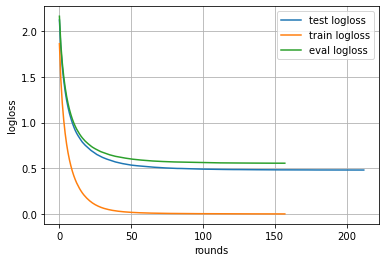

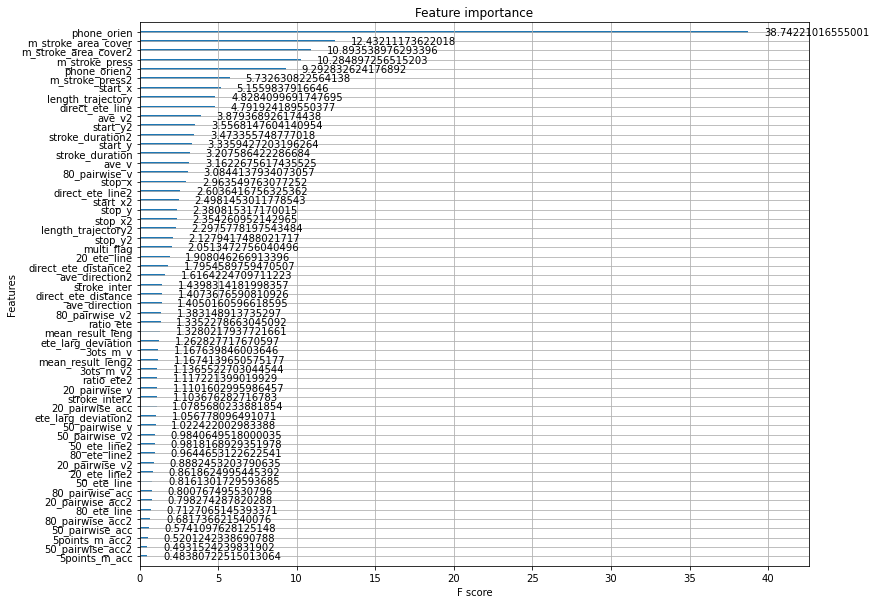

In [50]:
fx_addfeatures_drop = FeaturesExcept(columns_select_mf4, df_ori_t1, nfold=5)
X_train_fxad, X_test_fxad, y_train_fxad, y_test_fxad, matrix_fxad, y_pred_fxad = fx_addfeatures_drop.train()

In [51]:
check(X_train_fxad, X_test_fxad, y_train_fxad, y_test_fxad, matrix_fxad, y_pred_fxad)

              precision    recall  f1-score   support

           0       0.85      0.83      0.84        72
           1       0.95      0.96      0.96       239
           2       0.66      0.69      0.67       150
           3       0.92      0.83      0.88        42
           4       0.74      0.79      0.76        81
           5       0.81      0.83      0.82       110
           6       0.82      0.83      0.83       115
           7       0.86      0.94      0.90       121
           8       0.89      0.96      0.92        89
           9       0.81      0.76      0.79        75
          10       0.79      0.83      0.81        87
          11       0.91      0.94      0.93        67
          12       0.78      0.65      0.71        60
          13       0.89      0.95      0.92       128
          14       0.94      0.90      0.92       126
          15       0.81      0.76      0.78        74
          16       0.83      0.82      0.83       140
          17       0.83    